In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

#Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from numpy import argmax
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate

#log-reg libraries
from sklearn.impute import KNNImputer, SimpleImputer
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier


#metrics
from sklearn.metrics import accuracy_score, precision_recall_curve, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')


In [3]:
def credit_score(y_true, y_pred):

    # false positive
    fp = ((y_pred == 1) & (y_true == 0)).sum()

    # false negative
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    
    # true positive
    tp = ((y_pred == 1) & (y_true == 1)).sum()

    # true negative
    tn = ((y_pred == 0) & (y_true == 0)).sum()

    #specificity
    true_negative_rate = tn / (tn + fp)
    
    
    #recall
    true_positive_rate = tp / (tp + fn)
    
    # credit score: penalizes false negatives 
    cs_1 = 1 - (0.1*true_positive_rate + 0.9 * true_negative_rate)
    
    cs = 10*fn + fp
    
    return cs


In [4]:
def credit_metric(x, y):
    return 10*x+y

## 1. Introduction: observation des données et train-test split <a class="anchor" id="introduction"></a>

In [5]:
df = pd.read_csv('selected_feature_dataset')

In [6]:
df.head()

,TARGET,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR,ID
0,1.0,0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,...,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,NaN,NaN,NaN,100002
1,0.0,1,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,...,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,NaN,NaN,NaN,100003
2,0.0,0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,...,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,NaN,NaN,NaN,100004
3,0.0,1,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,...,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,NaN,0.0,0.0,100006
4,0.0,0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,...,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,NaN,NaN,NaN,100007


In [7]:
df.shape

(356231, 112)

In [8]:
df['TARGET']

0         1.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
356226    NaN
356227    NaN
356228    NaN
356229    NaN
356230    NaN
Name: TARGET, Length: 356231, dtype: float64

## Train-val-test split

In [9]:
# split the dataset: train == a une Target; test = n'a pas de Target; validation == partie du train set utilisé pour test
#(train-test split du train set)

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

X = train_df.drop(['TARGET', 'ID'], axis = 1)
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2)

# 2. modèles considérées: validation croisée des hyper-paramètres <a class="anchor" id="p1"></a>

On commence par estimer les modèles sur la base de l'AUC

puis, s'il y a indécision entre différents modèles: on passe par d'autres métriques (fonction de coût métiers, fbeta-score...)

On utilise des Cross validation pour quelques paramêtres au départ.

On propose un "fine-tuning" des hyperparamêtres sur le modèle qui semble le plus performant et sur la base de l'objectif métier.

Enfin, On réserve le recalibrage du dataset ("imbalanced data") uniquement pour les modèles qui en ont besoin (pas nécessaire pour les méthodes ensemblistes par exemple)

## Model 1 : DummyClassifier: stratifié, pas de "cross-validation"<a class="anchor" id="m0"></a>

In [10]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_train)

array([1., 1., 0., ..., 0., 0., 0.])

In [11]:
dummy_clf.score(X_train, y_train)

0.8515305500223587

In [12]:
y_train_prediction_base = dummy_clf.predict(X_train)

y_test_prediction_base = dummy_clf.predict(X_test)

y_train_prediction_proba_base = dummy_clf.predict_proba(X_train)[:, 1]

y_val_prediction_proba_base = dummy_clf.predict_proba(X_test)[:, 1]

In [13]:
auc_train_base = roc_auc_score(y_train, y_train_prediction_proba_base)

auc_test_base = roc_auc_score(y_test, y_val_prediction_proba_base)

print('AUC for the training set : '+str(auc_train_base))

print('AUC for the validation set : '+str(auc_test_base))

AUC for the training set : 0.4994479657388519
AUC for the validation set : 0.5009081471348383


In [14]:
fpr_train_base, tpr_train_base, _ = roc_curve(y_train, y_train_prediction_proba_base)

fpr_val_base, tpr_val_base, _ = roc_curve(y_test, y_val_prediction_proba_base)

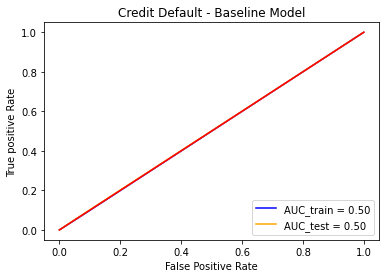

In [15]:
plt.plot(fpr_train_base, tpr_train_base, color='blue', label='AUC_train = %0.2f' % auc_train_base)
plt.plot(fpr_val_base, tpr_val_base, color='orange', label='AUC_test = %0.2f' % auc_test_base)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), color='red')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.title('Credit Default - Baseline Model')
plt.savefig('roc_curve.png', dpi=300)
plt.show()

In [16]:
print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, y_val_prediction_proba_base).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, y_val_prediction_proba_base))


print('credit_score validation : ', credit_metric(fn,fp))

fbs_dummy = fbeta_score(y_test, y_val_prediction_proba_base, beta=2)

print('f2_score validation : ', fbs_dummy)

auc_dummy = roc_auc_score(y_test, y_val_prediction_proba_base)

print('auc_score validation : ', auc_dummy)

---------------------------------------------------
matrice de confusion validation : 
true neg :  52047 , false pos :  4486 , false neg :  4562 , true pos :  403
--------------------------------------------------
classification report validation : 
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92     56533
         1.0       0.08      0.08      0.08      4965

    accuracy                           0.85     61498
   macro avg       0.50      0.50      0.50     61498
weighted avg       0.85      0.85      0.85     61498

credit_score validation :  50106
f2_score validation :  0.08141743100731343
auc_score validation :  0.5009081471348383


In [17]:
print('AUC for the training set : '+str(auc_train_base))

print('AUC for the validation set : '+str(auc_test_base))

print('---------------------------------------------------')

print('matrice de confusion entrainement : ' )

tn, fp, fn, tp = confusion_matrix(y_train, y_train_prediction_base).ravel()
print("true neg : ", tn, "false pos : ", fp, " false neg : ", fn, " true pos : ", tp)
print("--------------------------------------------------")

print('classification report entrainement : ' )
print(classification_report(y_train, y_train_prediction_base))


print('credit_score entrainement : ',credit_metric(fn,fp))

fbs_dummy = fbeta_score(y_train, y_train_prediction_base, beta=2)

print('f2_score entrainement : ', fbs_dummy)

auc_dummy = roc_auc_score(y_train, y_train_prediction_base)

print('auc_score entraînement : ', auc_dummy)

print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, y_test_prediction_base).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, y_test_prediction_base))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_dummy = fbeta_score(y_test, y_test_prediction_base, beta=2)

print('f2_score validation : ', fbs_dummy)

auc_dummy = roc_auc_score(y_test, y_test_prediction_base)

print('auc_score validation : ', auc_dummy)


AUC for the training set : 0.4994479657388519
AUC for the validation set : 0.5009081471348383
---------------------------------------------------
matrice de confusion entrainement : 
true neg :  207640 false pos :  18492  false neg :  18337  true pos :  1521
--------------------------------------------------
classification report entrainement : 
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92    226132
         1.0       0.08      0.08      0.08     19858

    accuracy                           0.85    245990
   macro avg       0.50      0.50      0.50    245990
weighted avg       0.85      0.85      0.85    245990

credit_score entrainement :  201862
f2_score entrainement :  0.07647443310372569
auc_score entraînement :  0.4974092848889793
---------------------------------------------------
matrice de confusion validation : 
true neg :  52019 , false pos :  4514 , false neg :  4551 , true pos :  414
------------------------------------

## Model 2 - LightGBM : pas de "cross-validation"<a class="anchor" id="m1"></a>

Dans cette section, on teste sur nos données traitées un modèle performant populaire sur kaggle. ce modèle sert de comparaison pour les autres résultats et de validation pour le traitement et le choix des features opérées.

Le classifieur Dummy sert de borne inférieur tandis que celui-ci nous permet de savoir comment nos modèles cross-validés se comportent par comparaison et si nos résultats sont bons.

In [18]:
lgb_train = lgb.Dataset(data=X_train, label=y_train)
lgb_eval = lgb.Dataset(data=X_test, label=y_test)

In [19]:
### Fit Model

params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059078 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 150 rounds
[200]	valid_0's auc: 0.763508
[400]	valid_0's auc: 0.776865
[600]	valid_0's auc: 0.782807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[800]	valid_0's auc: 0.786137
[1000]	valid_0's auc: 0.788143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1200]	valid_0's auc: 0.789615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1400]	valid_0's auc: 0.790368
[LightGBM] [Warning] No further spl

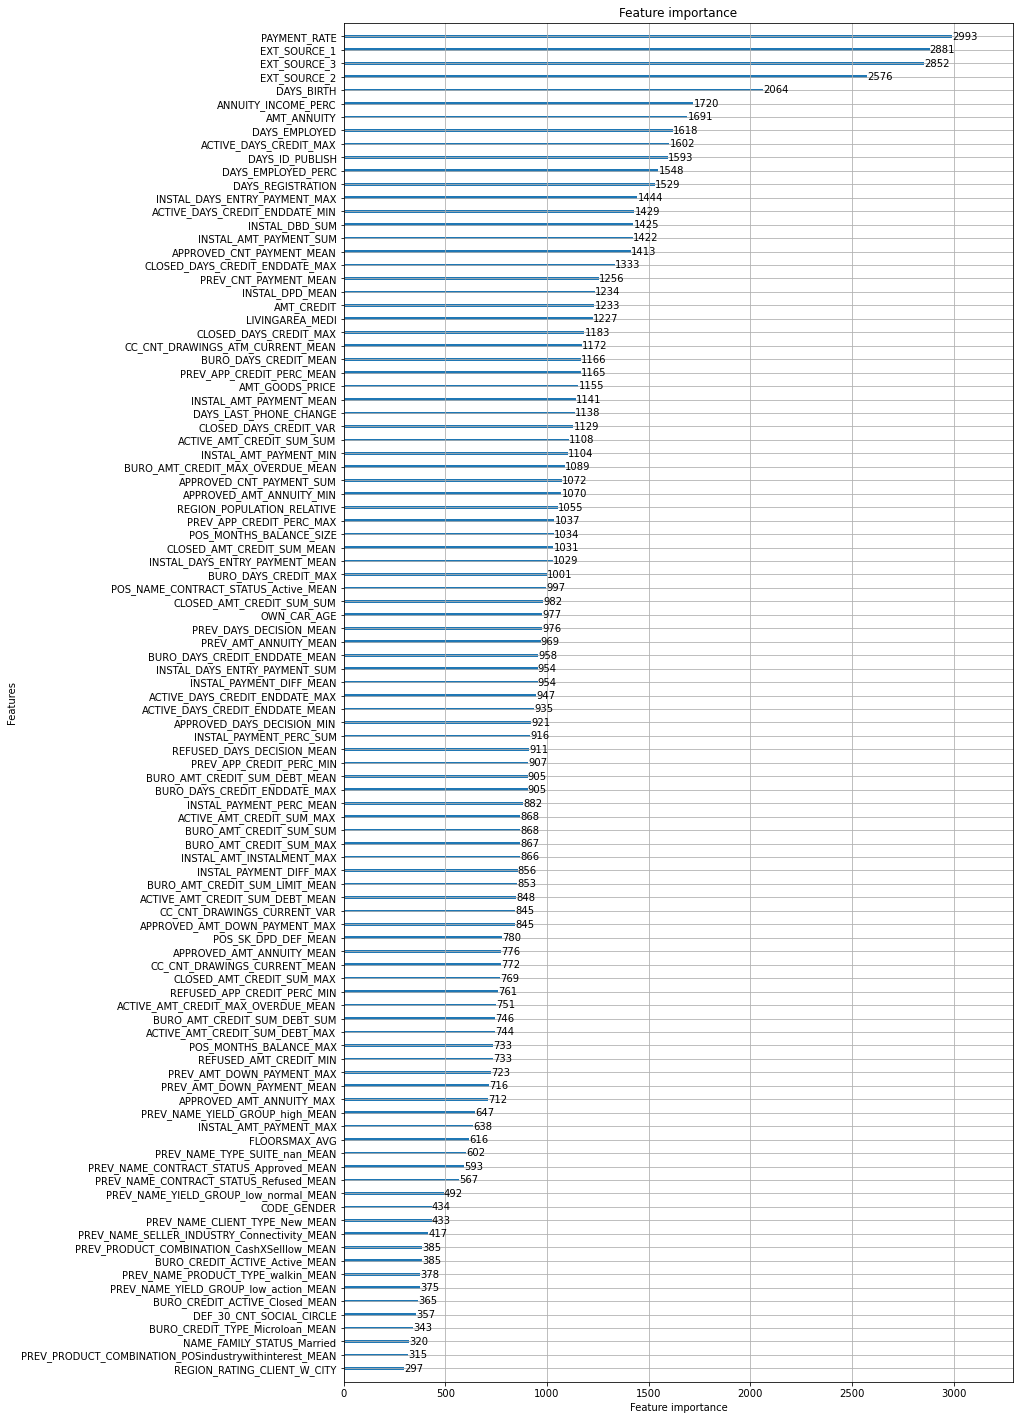

In [20]:
### Feature Importance

lgb.plot_importance(model, figsize=(12, 25), max_num_features=100);


In [21]:
### Prediction

preds = model.predict(test_df.drop(['TARGET', 'ID'], axis = 1))
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_df['ID']
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("lgb_baseline.csv", index=False)
sub_lgb.head()

,SK_ID_CURR,TARGET
307488,100001,0.038617
307489,100005,0.119923
307490,100013,0.037326
307491,100028,0.040447
307492,100038,0.155315


AUC for the training set : 0.8973226275312791
AUC for the validation set : 0.7911781885933925


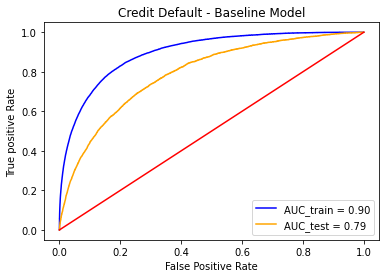

In [22]:
y_train_prediction_proba_lgb = model.predict(X_train)

y_val_prediction_proba_lgb = model.predict(X_test)

y_train_prediction_lgb = []

for i in y_train_prediction_proba_lgb:
    if i > 0.5: 
        y_train_prediction_lgb.append(1)
    else : 
        y_train_prediction_lgb.append(0)


y_test_prediction_lgb = []

for i in y_val_prediction_proba_lgb:
    if i > 0.5: 
        y_test_prediction_lgb.append(1)
    else : 
        y_test_prediction_lgb.append(0)


auc_train_lgb = roc_auc_score(y_train, y_train_prediction_proba_lgb)

auc_test_lgb = roc_auc_score(y_test, y_val_prediction_proba_lgb)

print('AUC for the training set : '+str(auc_train_lgb))

print('AUC for the validation set : '+str(auc_test_lgb))

fpr_train_lgb, tpr_train_lgb, _ = roc_curve(y_train, y_train_prediction_proba_lgb)

fpr_val_lgb, tpr_val_lgb, _ = roc_curve(y_test, y_val_prediction_proba_lgb)

plt.plot(fpr_train_lgb, tpr_train_lgb, color='blue', label='AUC_train = %0.2f' % auc_train_lgb)
plt.plot(fpr_val_lgb, tpr_val_lgb, color='orange', label='AUC_test = %0.2f' % auc_test_lgb)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), color='red')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.title('Credit Default - Baseline Model')
plt.savefig('roc_curve.png', dpi=300)
plt.show()

In [23]:
print('---------------------------------------------------')

auc_lgb = roc_auc_score(y_train, y_train_prediction_proba_lgb)

print('auc_score entrainement : ', auc_lgb)



auc_lgb = roc_auc_score(y_test, y_val_prediction_proba_lgb)

print('auc_score validation : ', auc_lgb)


---------------------------------------------------
auc_score entrainement :  0.8973226275312791
auc_score validation :  0.7911781885933925


In [24]:
print('AUC for the training set : '+str(auc_train_lgb))

print('AUC for the validation set : '+str(auc_test_lgb))

print('---------------------------------------------------')

print('matrice de confusion entrainement : ' )

tn, fp, fn, tp = confusion_matrix(y_train, y_train_prediction_lgb).ravel()
print("true neg : ", tn, "false pos : ", fp, " false neg : ", fn, " true pos : ", tp)
print("--------------------------------------------------")

print('classification report entrainement : ' )
print(classification_report(y_train, y_train_prediction_lgb))


print('credit_score entrainement : ', credit_metric(fn,fp))

fbs_lgb = fbeta_score(y_train, y_train_prediction_lgb, beta=2)

print('f2_score entrainement : ', fbs_lgb)

auc_lgb = roc_auc_score(y_train, y_train_prediction_lgb)

print('auc_score validation : ', auc_lgb)


print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, y_test_prediction_lgb).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, y_test_prediction_lgb))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_lgb = fbeta_score(y_test, y_test_prediction_lgb, beta=2)

print('f2_score validation : ', fbs_lgb)

auc_lgb = roc_auc_score(y_test, y_test_prediction_lgb)

print('auc_score validation : ', auc_lgb)


AUC for the training set : 0.8973226275312791
AUC for the validation set : 0.7911781885933925
---------------------------------------------------
matrice de confusion entrainement : 
true neg :  225836 false pos :  296  false neg :  17719  true pos :  2139
--------------------------------------------------
classification report entrainement : 
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    226132
         1.0       0.88      0.11      0.19     19858

    accuracy                           0.93    245990
   macro avg       0.90      0.55      0.58    245990
weighted avg       0.92      0.93      0.90    245990

credit_score entrainement :  177486
f2_score entrainement :  0.13063871889772435
auc_score validation :  0.5532029024598343
---------------------------------------------------
matrice de confusion validation : 
true neg :  56350 , false pos :  183 , false neg :  4750 , true pos :  215
-----------------------------------------

## Model 3: XGBoost<a class="anchor" id="m2"></a>

#### Notre premier véritable modèle avec cross-validation. Pour gérer le déséquilibre dans nos classes on indique des poids qui favorisent la classe minoritaire (1) ainsi que d'autres hyper-paramêtres sélectionné avec un GridSearchCV.

In [25]:
# On calcul d'abord le ratio de déséquilibre entre nos deux classes pour obtenir un ancrage
# autour duquel choisir des valeurs à tester lors de la cross-validation.

ratio = train_df[train_df['TARGET'] == 0].shape[0]/train_df[train_df['TARGET'] == 1].shape[0]

print(ratio)

11.387221528421222


In [26]:
XGBClassifier().get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [27]:
model = XGBClassifier(tree_method = 'gpu_hist', verbosity = 3)

n_estimators = [100, 200]

learning_rate = [0.01, 0.1]

weights = [9, 11, 13]

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, scale_pos_weight = weights)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

rand_search_xgb = RandomizedSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose = 3)


In [28]:
rand_search_xgb_results = rand_search_xgb.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[14:30:38] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_gpu_hist.cu:873: [GPU Hist]: Configure
[14:30:39] ======== Monitor (0): SketchContainer ========
[14:30:39] MakeCuts: 0.001177s, 1 calls @ 1177us

[14:30:39] Prune: 0.000828s, 1 calls @ 828us

[14:30:39] ScanInput: 0.003197s, 1 calls @ 3197us

[14:30:39] Unique: 0.000583s, 1 calls @ 583us

[14:30:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:30:45] ======== Monitor (0): Learner ========
[14:30:45] Configure: 0s, 1 calls @ 0us

[14:30:45] EvalOneIter: 0.000861s, 200 calls @ 861us

[14:30:45] GetGradient: 0.026789s, 200 calls @ 26789us

[14:30:45] PredictRaw: 0.113049s, 200 c

In [29]:
# summarize results
print("Best: %f using %s" % (rand_search_xgb_results.best_score_, rand_search_xgb_results.best_params_))
means = rand_search_xgb_results.cv_results_['mean_test_score']
stds = rand_search_xgb_results.cv_results_['std_test_score']
params = rand_search_xgb_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.781513 using {'scale_pos_weight': 9, 'n_estimators': 200, 'learning_rate': 0.1}
0.756104 (0.006305) with: {'scale_pos_weight': 13, 'n_estimators': 200, 'learning_rate': 0.01}
0.741432 (0.006690) with: {'scale_pos_weight': 9, 'n_estimators': 100, 'learning_rate': 0.01}
0.756081 (0.006363) with: {'scale_pos_weight': 11, 'n_estimators': 200, 'learning_rate': 0.01}
0.779925 (0.005524) with: {'scale_pos_weight': 9, 'n_estimators': 100, 'learning_rate': 0.1}
0.741380 (0.006526) with: {'scale_pos_weight': 11, 'n_estimators': 100, 'learning_rate': 0.01}
0.756081 (0.006375) with: {'scale_pos_weight': 9, 'n_estimators': 200, 'learning_rate': 0.01}
0.781089 (0.005746) with: {'scale_pos_weight': 11, 'n_estimators': 200, 'learning_rate': 0.1}
0.741359 (0.006755) with: {'scale_pos_weight': 13, 'n_estimators': 100, 'learning_rate': 0.01}
0.781513 (0.005488) with: {'scale_pos_weight': 9, 'n_estimators': 200, 'learning_rate': 0.1}
0.779393 (0.005888) with: {'scale_pos_weight': 13, 'n_estimators

In [30]:
y_predict_train_gbt = rand_search_xgb_results.predict(X_train)

y_predict_test_gbt = rand_search_xgb_results.predict(X_test)

y_train_prediction_proba_gbt = rand_search_xgb_results.predict_proba(X_train)[:, 1]

y_test_prediction_proba_gbt = rand_search_xgb_results.predict_proba(X_test)[:, 1]

[14:30:45] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_gpu_hist.cu:873: [GPU Hist]: Configure
[14:30:45] ======== Device 0 Memory Allocations:  ========
[14:30:45] Peak memory usage: 353MiB
[14:30:45] Number of allocations: 32082
[14:30:45] ======== Monitor (0):  ========


In [31]:
#graph roc curve

auc_train_gbt = roc_auc_score(y_train, y_train_prediction_proba_gbt)

auc_test_gbt = roc_auc_score(y_test, y_test_prediction_proba_gbt)

print('AUC for the training set : '+str(auc_train_gbt))

print('AUC for the testing set : '+str(auc_test_gbt))

fpr_train_gbt, tpr_train_gbt, _ = roc_curve(y_train, y_train_prediction_proba_gbt)

fpr_test_gbt, tpr_test_gbt, _ = roc_curve(y_test, y_test_prediction_proba_gbt)

AUC for the training set : 0.8866089683482956
AUC for the testing set : 0.7840285675457423


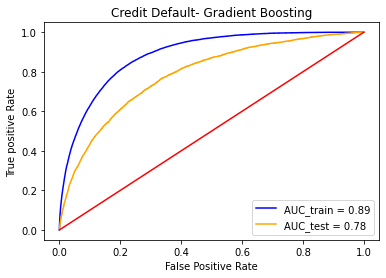

In [32]:
plt.plot(fpr_train_gbt, tpr_train_gbt, color='blue', label='AUC_train = %0.2f' % auc_train_gbt)
plt.plot(fpr_test_gbt, tpr_test_gbt, color='orange', label='AUC_test = %0.2f' % auc_test_gbt)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), color='red')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.title('Credit Default- Gradient Boosting')
plt.savefig('roc_curve.png', dpi=300)
plt.show()

In [33]:
y_predict_train_gbt.shape

(245990,)

In [34]:
tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train_gbt).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_train, y_predict_train_gbt))

189429 36703 4829 15029
              precision    recall  f1-score   support

         0.0       0.98      0.84      0.90    226132
         1.0       0.29      0.76      0.42     19858

    accuracy                           0.83    245990
   macro avg       0.63      0.80      0.66    245990
weighted avg       0.92      0.83      0.86    245990



In [35]:
credit_metric(fn,fp)

84993

In [36]:
fbs_gbt = fbeta_score(y_train, y_predict_train_gbt, beta=10)

print(fbs_gbt)

0.7449841278566423


In [37]:
predict_application_test_xgb = rand_search_xgb_results.predict(test_df.drop(['ID', 'TARGET'], axis = 1))
predict_proba_application_test_xgb = rand_search_xgb_results.predict_proba(test_df.drop(['ID', 'TARGET'], axis = 1))

In [38]:
predict_proba_application_test_xgb

array([[0.69779205, 0.30220795],
       [0.44793487, 0.55206513],
       [0.7810661 , 0.2189339 ],
       ...,
       [0.96464455, 0.03535547],
       [0.64239526, 0.35760477],
       [0.27979052, 0.7202095 ]], dtype=float32)

In [39]:
print('AUC for the training set : '+str(auc_train_gbt))

print('AUC for the testing set : '+str(auc_test_gbt))

print('---------------------------------------------------')

print('matrice de confusion entrainement : ' )

tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train_gbt).ravel()
print("true neg : ", tn, "false pos : ", fp, " false neg : ", fn, " true pos : ", tp)
print("--------------------------------------------------")

print('classification report entrainement : ' )
print(classification_report(y_train, y_predict_train_gbt))


print('credit_score entrainement : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_train, y_predict_train_gbt, beta=2)

print('f2_score entrainement : ', fbs_gbt)

auc_gbt = roc_auc_score(y_train, y_predict_train_gbt)

print('auc_score entraînement : ', auc_gbt)

print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test_gbt).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, y_predict_test_gbt))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_test, y_predict_test_gbt, beta=2)

print('f2_score validation : ', fbs_gbt)

auc_gbt = roc_auc_score(y_test, y_predict_test_gbt)

print('auc_score validation : ', auc_gbt)

AUC for the training set : 0.8866089683482956
AUC for the testing set : 0.7840285675457423
---------------------------------------------------
matrice de confusion entrainement : 
true neg :  189429 false pos :  36703  false neg :  4829  true pos :  15029
--------------------------------------------------
classification report entrainement : 
              precision    recall  f1-score   support

         0.0       0.98      0.84      0.90    226132
         1.0       0.29      0.76      0.42     19858

    accuracy                           0.83    245990
   macro avg       0.63      0.80      0.66    245990
weighted avg       0.92      0.83      0.86    245990

credit_score entrainement :  84993
f2_score entrainement :  0.5729087249550182
auc_score entraînement :  0.7972577954405827
---------------------------------------------------
matrice de confusion validation : 
true neg :  46755 , false pos :  9778 , false neg :  2136 , true pos :  2829
----------------------------------------

## Model 4 : Regression logistique<a class="anchor" id="m3"></a>

In [40]:
# la reg. log. n'accepte pas les valeurs manquantes. On décide d'utiliser un simple imputer
# avec comme stratégie d'assigner la médiane de la feature à la valeurs manquantes. 

simple_imputer = SimpleImputer(strategy='median')

pre_imputed_df = df.drop(['TARGET'], axis = 1)

simple_imputer.fit(pre_imputed_df)

print('DONE')

imputed_df_median = simple_imputer.transform(pre_imputed_df)

print('DONE')
imputed_df_median = pd.DataFrame(imputed_df_median, columns = pre_imputed_df.columns )
imputed_df_median = imputed_df_median.join(df['TARGET'])

DONE
DONE


In [41]:
imputed_df_median.drop(['TARGET'], axis = 1).isnull().sum().sum()

0

In [42]:
imputed_df_median.isnull().sum().sum()

48743

In [43]:
# split the dataset: train == a une Target; test = n'a pas de Target; validation == partie du train set utilisé pour test
#(train-test split du train set)

train_imp_df = imputed_df_median[imputed_df_median['TARGET'].notnull()]
test_imp_df = imputed_df_median[imputed_df_median['TARGET'].isnull()]

X = train_imp_df.drop(['TARGET', 'ID'], axis = 1)
y = train_imp_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2)

In [44]:
print(X_train.isnull().sum().sum())
y_train.isnull().sum().sum()

0


0

#### Modèle sans traitement du déséquilibre

In [45]:
# define model
model = LogisticRegression()

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose = 3)

print('Mean ROC AUC: %.3f' % np.mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   54.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   54.8s finished


Mean ROC AUC: 0.625


#### Modèle avec oversampling smote sur le set d'entraînement

In [46]:
# define model
model = LogisticRegression()

# define pipeline
steps = [('over', SMOTE()), ('model', model)]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose = 2)

print('Mean ROC AUC: %.3f' % np.mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished


Mean ROC AUC: 0.638


#### Modèle avec oversampling et undersampling sur le set d'entraînement

In [47]:
# values to evaluate
k_values = [1, 2, 3, 4, 5, 6, 7]

param_grid_log_reg = {'over__k_neighbors': [1, 2, 3, 4, 5, 6, 7] ,'model__C': [ 0.01, 0.1, 1, 10] ,'model__penalty':['l1','l2']}

# define pipeline
model = LogisticRegression()
#grid_log_reg = GridSearchCV(model, param_grid_log_reg, verbose = 3).fit(X_train, y_train)

over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
    
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_log_reg = RandomizedSearchCV(pipeline, param_grid_log_reg, scoring='roc_auc', cv=cv, n_jobs=-1, verbose = 3)

score_list = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, verbose = 2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   50.6s finished


In [48]:
print('Mean ROC AUC: %.3f' % np.mean(score_list))


Mean ROC AUC: 0.649


In [49]:
grid_log_results = grid_log_reg.fit(X_train, y_train)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


In [50]:
# summarize results
print("Best: %f using %s" % (grid_log_results.best_score_, grid_log_results.best_params_))
means = grid_log_results.cv_results_['mean_test_score']
stds = grid_log_results.cv_results_['std_test_score']
params = grid_log_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.649670 using {'over__k_neighbors': 7, 'model__penalty': 'l2', 'model__C': 10}
nan (nan) with: {'over__k_neighbors': 1, 'model__penalty': 'l1', 'model__C': 0.1}
0.647940 (0.006143) with: {'over__k_neighbors': 7, 'model__penalty': 'l2', 'model__C': 0.01}
0.648772 (0.005170) with: {'over__k_neighbors': 5, 'model__penalty': 'l2', 'model__C': 1}
0.648732 (0.005304) with: {'over__k_neighbors': 4, 'model__penalty': 'l2', 'model__C': 1}
0.649030 (0.005645) with: {'over__k_neighbors': 2, 'model__penalty': 'l2', 'model__C': 1}
0.648970 (0.004321) with: {'over__k_neighbors': 1, 'model__penalty': 'l2', 'model__C': 1}
nan (nan) with: {'over__k_neighbors': 1, 'model__penalty': 'l1', 'model__C': 10}
0.649372 (0.005374) with: {'over__k_neighbors': 3, 'model__penalty': 'l2', 'model__C': 0.01}
0.649670 (0.005523) with: {'over__k_neighbors': 7, 'model__penalty': 'l2', 'model__C': 10}
nan (nan) with: {'over__k_neighbors': 6, 'model__penalty': 'l1', 'model__C': 0.1}


AUC for the training set : 0.6511827141740372
AUC for the testing set : 0.6503878020856341


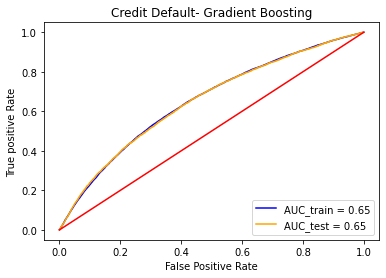

In [51]:
y_predict_train_log = grid_log_results.predict(X_train)

y_predict_test_log = grid_log_results.predict(X_test)

y_train_prediction_proba_log = grid_log_results.predict_proba(X_train)[:, 1]

y_test_prediction_proba_log = grid_log_results.predict_proba(X_test)[:, 1]


#graph roc curve

auc_train_log = roc_auc_score(y_train, y_train_prediction_proba_log)

auc_test_log = roc_auc_score(y_test, y_test_prediction_proba_log)

print('AUC for the training set : '+str(auc_train_log))

print('AUC for the testing set : '+str(auc_test_log))

fpr_train_log, tpr_train_log, _ = roc_curve(y_train, y_train_prediction_proba_log)

fpr_test_log, tpr_test_log, _ = roc_curve(y_test, y_test_prediction_proba_log)

plt.plot(fpr_train_log, tpr_train_log, color='blue', label='AUC_train = %0.2f' % auc_train_log)
plt.plot(fpr_test_log, tpr_test_log, color='orange', label='AUC_test = %0.2f' % auc_test_log)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), color='red')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.title('Credit Default- Gradient Boosting')
plt.savefig('roc_curve.png', dpi=300)
plt.show()


In [52]:
y_predict_train_log.shape

(245990,)

In [53]:
tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train_log).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_train, y_predict_train_log))

print(credit_metric(fn,fp))

fbs_log = fbeta_score(y_train, y_predict_train_log, beta=2)

print(fbs_log)

220495 5637 18575 1283
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95    226132
         1.0       0.19      0.06      0.10     19858

    accuracy                           0.90    245990
   macro avg       0.55      0.52      0.52    245990
weighted avg       0.86      0.90      0.88    245990

191387
0.07428895682786733


In [54]:
predict_application_test_log = grid_log_results.predict(test_imp_df.drop(['ID', 'TARGET'], axis = 1))
predict_proba_application_test_log = grid_log_results.predict_proba(test_imp_df.drop(['ID', 'TARGET'], axis = 1))

predict_proba_application_test_log

array([[0.53105691, 0.46894309],
       [0.5904952 , 0.4095048 ],
       [0.76399519, 0.23600481],
       ...,
       [0.75006898, 0.24993102],
       [0.71883638, 0.28116362],
       [0.64809656, 0.35190344]])

In [55]:
print('AUC for the training set : '+str(auc_train_log))
print('AUC for the testing set : '+str(auc_test_log))

print('---------------------------------------------------')

print('matrice de confusion entrainement : ' )

tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train_log).ravel()
print("true neg : ", tn, "false pos : ", fp, " false neg : ", fn, " true pos : ", tp)
print("--------------------------------------------------")

print('classification report entrainement : ' )
print(classification_report(y_train, y_predict_train_log))


print('credit_score entrainement : ',credit_metric(fn,fp))

fbs_log = fbeta_score(y_train, y_predict_train_log, beta=2)

print('f2_score entrainement : ', fbs_log)

print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test_log).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, y_predict_test_log))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_log = fbeta_score(y_test, y_predict_test_log, beta=2)

print('f2_score validation : ', fbs_log)

auc_log = roc_auc_score(y_test, y_predict_test_log)

print('auc_score validation : ', auc_log)

AUC for the training set : 0.6511827141740372
AUC for the testing set : 0.6503878020856341
---------------------------------------------------
matrice de confusion entrainement : 
true neg :  220495 false pos :  5637  false neg :  18575  true pos :  1283
--------------------------------------------------
classification report entrainement : 
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95    226132
         1.0       0.19      0.06      0.10     19858

    accuracy                           0.90    245990
   macro avg       0.55      0.52      0.52    245990
weighted avg       0.86      0.90      0.88    245990

credit_score entrainement :  191387
f2_score entrainement :  0.07428895682786733
---------------------------------------------------
matrice de confusion validation : 
true neg :  55145 , false pos :  1388 , false neg :  4652 , true pos :  313
--------------------------------------------------
classification report validation :

## Modele 5: RandomForestClassifier<a class="anchor" id="m4"></a>

In [56]:
#même principe que reg log. pas d'oversampling mais ajustement des weights.

simple_imputer = SimpleImputer(strategy='median')

pre_imputed_df = df.drop(['TARGET'], axis = 1)

simple_imputer.fit(pre_imputed_df)

print('DONE')

imputed_df_median = simple_imputer.transform(pre_imputed_df)

print('DONE')
imputed_df_median = pd.DataFrame(imputed_df_median, columns = pre_imputed_df.columns )
imputed_df_median = imputed_df_median.join(df['TARGET'])

DONE
DONE


In [57]:
# split the dataset: train == a une Target; test = n'a pas de Target; validation == partie du train set utilisé pour test
#(train-test split du train set)

train_rf_df = imputed_df_median[imputed_df_median['TARGET'].notnull()]
test_rf_df = imputed_df_median[imputed_df_median['TARGET'].isnull()]

X = train_rf_df.drop(['TARGET', 'ID'], axis = 1)
y = train_rf_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2)

In [58]:
# We first establish the imbalance ratio to get a baseline for the values of our hyperparameters

ratio = train_rf_df[train_rf_df['TARGET'] == 0].shape[0]/train_rf_df[train_rf_df['TARGET'] == 1].shape[0]

print(ratio)

11.387221528421222


In [59]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [60]:
rf = RandomForestClassifier(bootstrap = True, class_weight = 'balanced_subsample', max_depth = 2, max_features = 4,
                            oob_score=True, verbose = 3)

In [61]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [62]:
#dernier test: nombre d'estimateurs

n_estimators = [100, 200, 300]

param_grid = dict(n_estimators=n_estimators)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

rand_search_rf = GridSearchCV(rf, param_grid, scoring="roc_auc", n_jobs=-1, cv=cv, verbose = 3)


In [63]:
rand_search_rf_result = rand_search_rf.fit(X_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   23.9s finished


In [64]:
rand_search_rf_result.score(X_test,y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished


0.7160279457128562

In [65]:
rf = RandomForestClassifier(bootstrap = True, class_weight = 'balanced_subsample', max_depth = 2, max_features = 4,
                            n_estimators=200, oob_score=True, verbose = 3).fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 200
building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   23.3s finished


In [66]:
rf.score(X_test,y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished


0.6591921688510195

In [67]:
y_predict_train_rf = rf.predict(X_train)

y_predict_test_rf = rf.predict(X_test)

y_train_prediction_proba_rf = rf.predict_proba(X_train)[:, 1]

y_test_prediction_proba_rf = rf.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

Feature: 0, Score: 0.01308
Feature: 1, Score: 0.00302
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00743
Feature: 4, Score: 0.00212
Feature: 5, Score: 0.02634
Feature: 6, Score: 0.04626
Feature: 7, Score: 0.00127
Feature: 8, Score: 0.00761
Feature: 9, Score: 0.00225
Feature: 10, Score: 0.00415
Feature: 11, Score: 0.00824
Feature: 12, Score: 0.05585
Feature: 13, Score: 0.07415
Feature: 14, Score: 0.05421
Feature: 15, Score: 0.00381
Feature: 16, Score: 0.00152
Feature: 17, Score: 0.00005
Feature: 18, Score: 0.00594
Feature: 19, Score: 0.01203
Feature: 20, Score: 0.00141
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.01406
Feature: 23, Score: 0.03398
Feature: 24, Score: 0.01047
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.03309
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.01099
Feature: 31, Score: 0.03487
Feature: 32, Score: 0.03249
Feature: 33, Score: 0.00651
Feature: 34, Score: 0.02662
Feature: 35, Score: 0.00000
Fe

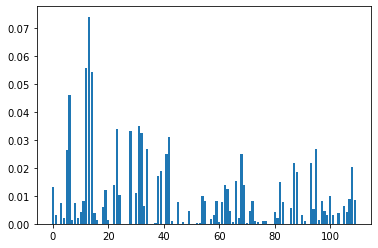

In [68]:
importance = rf.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))],importance)
plt.show()

In [69]:
auc_train_rf = roc_auc_score(y_train, y_train_prediction_proba_rf)

auc_test_rf = roc_auc_score(y_test, y_test_prediction_proba_rf)

print('AUC for the training set : '+str(auc_train_rf))

print('AUC for the testing set : '+str(auc_test_rf))


AUC for the training set : 0.725986890664186
AUC for the testing set : 0.720163750751751


In [70]:
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train, y_train_prediction_proba_rf)

fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_test_prediction_proba_rf)

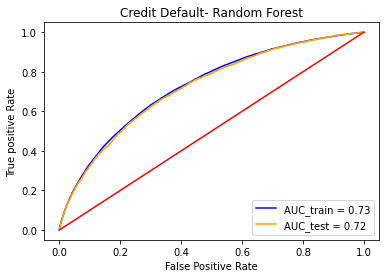

In [71]:
plt.plot(fpr_train_rf, tpr_train_rf, color='blue', label='AUC_train = %0.2f' % auc_train_rf)
plt.plot(fpr_test_rf, tpr_test_rf, color='orange', label='AUC_test = %0.2f' % auc_test_rf)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), color='red')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.title('Credit Default- Random Forest')
plt.savefig('roc_curve.png', dpi=300)
plt.show()

In [72]:
print('AUC for the training set : '+str(auc_train_rf))

print('AUC for the testing set : '+str(auc_test_rf))

print('---------------------------------------------------')

print('matrice de confusion entrainement : ' )

tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train_rf).ravel()
print("true neg : ", tn, "false pos : ", fp, " false neg : ", fn, " true pos : ", tp)
print("--------------------------------------------------")

print('classification report entrainement : ' )
print(classification_report(y_train, y_predict_train_rf))


print('credit_score entrainement : ', credit_metric(fn,fp))

fbs_rf = fbeta_score(y_train, y_predict_train_rf, beta=2)

print('f2_score entrainement : ', fbs_rf)

print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test_rf).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, y_predict_test_rf))


print('credit_score validation : ', credit_metric(fn,fp))

fbs_rf = fbeta_score(y_test, y_predict_test_rf, beta=2)

print('f2_score validation : ', fbs_rf)

auc_rf = roc_auc_score(y_test, y_predict_test_rf)

print('auc_score validation : ', auc_rf)

AUC for the training set : 0.725986890664186
AUC for the testing set : 0.720163750751751
---------------------------------------------------
matrice de confusion entrainement : 
true neg :  149090 false pos :  77042  false neg :  6506  true pos :  13352
--------------------------------------------------
classification report entrainement : 
              precision    recall  f1-score   support

         0.0       0.96      0.66      0.78    226132
         1.0       0.15      0.67      0.24     19858

    accuracy                           0.66    245990
   macro avg       0.55      0.67      0.51    245990
weighted avg       0.89      0.66      0.74    245990

credit_score entrainement :  142102
f2_score entrainement :  0.39310824019879176
---------------------------------------------------
matrice de confusion validation : 
true neg :  37236 , false pos :  19297 , false neg :  1662 , true pos :  3303
--------------------------------------------------
classification report validation 

# 3. Optimisation Modèle final: XGboost<a class="anchor" id="p2"></a>

### Tuning pour problématique métier

## 3.1 Nested cross_validation avec RepeatedStratifiedKFold: plage d'hyperparamêtres<a class="anchor" id="e1"></a>

Best: 0.780240 using {'scale_pos_weight': 11, 'n_estimators': 200, 'learning_rate': 0.1}


In [73]:
## on opère une nouvelle cross-validation avec auc sur les valeurs bornes de nos paramêtres. + RepeatedStratifiedKfold 3 fois.

In [74]:
df = pd.read_csv('selected_feature_dataset')


train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

X = train_df.drop(['TARGET', 'ID'], axis = 1)
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2)

In [75]:
XGBClassifier().get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [76]:
model = XGBClassifier(scale_pos_weight = 11, tree_method = 'gpu_hist', verbosity = 3)

n_estimators = [200, 300, 500]

learning_rate = [0.1, 0.2, 0.5]

param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

rand_search_xgb = RandomizedSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=cv, verbose = 3)


In [77]:
rand_search_xgb_results = rand_search_xgb.fit(X_train, y_train)

Fitting 30 folds for each of 9 candidates, totalling 270 fits
[15:25:09] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_gpu_hist.cu:873: [GPU Hist]: Configure
[15:25:09] ======== Monitor (0): SketchContainer ========
[15:25:09] MakeCuts: 0.000781s, 1 calls @ 781us

[15:25:09] Prune: 0.000523s, 1 calls @ 523us

[15:25:09] ScanInput: 0.003024s, 1 calls @ 3024us

[15:25:09] Unique: 0.000372s, 1 calls @ 372us

[15:25:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:15] ======== Monitor (0): Learner ========
[15:25:15] Configure: 0.000384s, 1 calls @ 384us

[15:25:15] EvalOneIter: 0.000736s, 200 calls @ 736us

[15:25:15] GetGradient: 0.025229s, 200 calls @ 25229us

[15:25:15] PredictRaw: 0.000432s

In [78]:
# summarize results
print("Best: %f using %s" % (rand_search_xgb_results.best_score_, rand_search_xgb_results.best_params_))
means = rand_search_xgb_results.cv_results_['mean_test_score']
stds = rand_search_xgb_results.cv_results_['std_test_score']
params = rand_search_xgb_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.780277 using {'n_estimators': 200, 'learning_rate': 0.1}
0.780277 (0.005755) with: {'n_estimators': 200, 'learning_rate': 0.1}
0.777809 (0.005445) with: {'n_estimators': 300, 'learning_rate': 0.1}
0.771476 (0.005149) with: {'n_estimators': 500, 'learning_rate': 0.1}
0.767089 (0.005729) with: {'n_estimators': 200, 'learning_rate': 0.2}
0.760977 (0.005814) with: {'n_estimators': 300, 'learning_rate': 0.2}
0.750956 (0.005773) with: {'n_estimators': 500, 'learning_rate': 0.2}
0.727117 (0.005396) with: {'n_estimators': 200, 'learning_rate': 0.5}
0.718461 (0.006046) with: {'n_estimators': 300, 'learning_rate': 0.5}
0.712111 (0.006014) with: {'n_estimators': 500, 'learning_rate': 0.5}


[15:25:15] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_gpu_hist.cu:873: [GPU Hist]: Configure
[15:25:15] ======== Device 0 Memory Allocations:  ========
[15:25:15] Peak memory usage: 353MiB
[15:25:15] Number of allocations: 64149
[15:25:15] ======== Monitor (0):  ========
---------------------------------------------------
AUC for the training set : 0.8863255672328705
AUC for the testing set : 0.7862222599392927
---------------------------------------------------


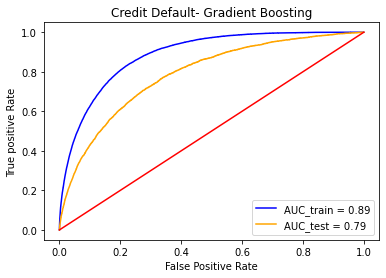

---------------------------------------------------
179825 46307 3720 16138
              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88    226132
         1.0       0.26      0.81      0.39     19858

    accuracy                           0.80    245990
   macro avg       0.62      0.80      0.64    245990
weighted avg       0.92      0.80      0.84    245990

83507
fbéta_score avec beta de 10 :  0.7957729666128808
---------------------------------------------------
AUC for the training set : 0.8863255672328705
AUC for the testing set : 0.7862222599392927
---------------------------------------------------
matrice de confusion entrainement : 
true neg :  179825 false pos :  46307  false neg :  3720  true pos :  16138
--------------------------------------------------
classification report entrainement : 
              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88    226132
         1.0       0.26      0.81  

In [79]:
y_predict_train_gbt = rand_search_xgb_results.predict(X_train)

y_predict_test_gbt = rand_search_xgb_results.predict(X_test)

y_train_prediction_proba_gbt = rand_search_xgb_results.predict_proba(X_train)[:, 1]

y_test_prediction_proba_gbt = rand_search_xgb_results.predict_proba(X_test)[:, 1]

print('---------------------------------------------------')

#graph roc curve

auc_train_gbt = roc_auc_score(y_train, y_train_prediction_proba_gbt)

auc_test_gbt = roc_auc_score(y_test, y_test_prediction_proba_gbt)

print('AUC for the training set : '+str(auc_train_gbt))

print('AUC for the testing set : '+str(auc_test_gbt))

print('---------------------------------------------------')

fpr_train_gbt, tpr_train_gbt, _ = roc_curve(y_train, y_train_prediction_proba_gbt)

fpr_test_gbt, tpr_test_gbt, _ = roc_curve(y_test, y_test_prediction_proba_gbt)

plt.plot(fpr_train_gbt, tpr_train_gbt, color='blue', label='AUC_train = %0.2f' % auc_train_gbt)
plt.plot(fpr_test_gbt, tpr_test_gbt, color='orange', label='AUC_test = %0.2f' % auc_test_gbt)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), color='red')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.title('Credit Default- Gradient Boosting')
plt.savefig('roc_curve.png', dpi=300)
plt.show()

print('---------------------------------------------------')

tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train_gbt).ravel()
print(tn, fp, fn, tp)
print(classification_report(y_train, y_predict_train_gbt))

print(credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_train, y_predict_train_gbt, beta=10)

print('fbéta_score avec beta de 10 : ',fbs_gbt)

print('---------------------------------------------------')

print('AUC for the training set : '+str(auc_train_gbt))

print('AUC for the testing set : '+str(auc_test_gbt))

print('---------------------------------------------------')

print('matrice de confusion entrainement : ' )

tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train_gbt).ravel()
print("true neg : ", tn, "false pos : ", fp, " false neg : ", fn, " true pos : ", tp)
print("--------------------------------------------------")

print('classification report entrainement : ' )
print(classification_report(y_train, y_predict_train_gbt))


print('credit_score entrainement : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_train, y_predict_train_gbt, beta=2)

print('f2_score entrainement : ', fbs_gbt)

auc_gbt = roc_auc_score(y_train, y_predict_train_gbt)

print('auc_score entraînement : ', auc_gbt)

print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test_gbt).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, y_predict_test_gbt))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_test, y_predict_test_gbt, beta=2)

print('f2_score validation : ', fbs_gbt)

auc_gbt = roc_auc_score(y_test, y_predict_test_gbt)

print('auc_score validation : ', auc_gbt)

## 3.2 Stratégies d'Optimisation: Score de couts metiers et métrique spécifique<a class="anchor" id="e2"></a>

### Il est préférable de ne pas donner un crédit à quelqu'un qui aurait été capable de le rembourser plutôt que d'en donner un à quelqu'un qui ne remboursera pas.

On cherche à prédire si qqn fera défaut. la classe positive est 1 (il fera défaut). négative est 0 (il ne fera pas défaut).

Ainsi, si 1) quelqu'un est classer comme positif ('1', fera défaut) mais ne l'est pas ('0', ne fera pas défaut) (faux positif) bien moins grave que 2) classer comme négatif ('0', ne fera pas défaut) alors qu'il est positif ( '1' - fera défaut ) ( faux négatif ). On lui a accordé un crédit qu'il ne peut pas rembourser, on perd de l'argent ( plutôt que l'opportunité d'en gagner plus ).

on cherche à minimiser au maximum les erreurs de type II (faux négatifs - situation 2)) en maintenant de bon scores AUC et un minimum d'erreur de type I (faux positifs - situation 1)) raisonnable.

un score intéressant de ce point de vue là est le fbéta-score avec un béta de 2 : https://machinelearningmastery.com/fbeta-measure-for-machine-learning/


In [80]:
train_df[train_df['TARGET']==1].shape

(24823, 112)

In [81]:
train_df[train_df['TARGET']==0].shape

(282665, 112)

In [82]:
predict_application_test_gbt = rand_search_xgb_results.predict(test_df.drop(['ID', 'TARGET'], axis = 1))
predict_proba_application_test_gbt = rand_search_xgb_results.predict_proba(test_df.drop(['ID', 'TARGET'], axis = 1))

predict_proba_application_test_gbt

array([[0.7083684 , 0.29163155],
       [0.3982079 , 0.6017921 ],
       [0.74763465, 0.25236538],
       ...,
       [0.9705432 , 0.02945682],
       [0.7321412 , 0.2678588 ],
       [0.19643962, 0.8035604 ]], dtype=float32)

In [83]:
auc_gbt = roc_auc_score(y_test, y_predict_test_gbt)

print('auc_score validation : ', auc_gbt)

auc_score validation :  0.708701456424608


In [84]:
print('---------------------------------------------------')

print('matrice de confusion entrainement : ' )

tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train_gbt).ravel()
print("true neg : ", tn, "false pos : ", fp, " false neg : ", fn, " true pos : ", tp)
print("--------------------------------------------------")

print('classification report entrainement : ' )
print(classification_report(y_train, y_predict_train_gbt))


print('credit_score entrainement : ', credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_train, y_predict_train_gbt, beta=2)

print('f2_score entrainement : ', fbs_gbt)

print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test_gbt).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, y_predict_test_gbt))


print('credit_score validation : ', credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_test, y_predict_test_gbt, beta=2)

print('f2_score validation : ', fbs_gbt)

auc_gbt = roc_auc_score(y_test, y_predict_test_gbt)

print('auc_score validation : ', auc_gbt)

---------------------------------------------------
matrice de confusion entrainement : 
true neg :  179825 false pos :  46307  false neg :  3720  true pos :  16138
--------------------------------------------------
classification report entrainement : 
              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88    226132
         1.0       0.26      0.81      0.39     19858

    accuracy                           0.80    245990
   macro avg       0.62      0.80      0.64    245990
weighted avg       0.92      0.80      0.84    245990

credit_score entrainement :  83507
f2_score entrainement :  0.5687320707373289
---------------------------------------------------
matrice de confusion validation : 
true neg :  44081 , false pos :  12452 , false neg :  1799 , true pos :  3166
--------------------------------------------------
classification report validation : 
              precision    recall  f1-score   support

         0.0       0.96      0.78

### Que faire pour rendre nos prédictions meilleurs du point de vue métier?

On pourrait encore accroître artificiellement les poids associés à la classe positive/minoritaire pour rendre les erreurs sur la classe minoritaires plus couteuses. -> comme les classes étaient déséquilibrée, on a déjà chercher à optimiser ces poids avec une cross-validation. La valeurs optimal pour l'hyperparamêtre était de 11 avec l'auc comme score. Modifié les poids, c'est donc prendre le risque d'une prédiction bien moins bonne. Celà ne semble pas la meilleur approche.
 
On cherchera plutôt à utiliser les scores métiers comme le crédit_score ou le f2_score pour rechercher un seuil de prédiction convenable étant donné les meilleurs prédictions possible du point de vue de l'auc. On continue d'optimiser pour les différents hyper-paramêtres en cherchant à réduire le sur-apprentissage du modèle et à affiner les hyper-paramêtres optimaux. On observe différents scores lors de cette optimisation en maintenant le refit auc. 

Enfin, on cherche le seuil acceptable pour l'entreprise, en essayant de privilégier le recall donc.

In [85]:
y_test_prediction_proba_gbt

array([0.8969233 , 0.23336951, 0.8117311 , ..., 0.17126215, 0.27486163,
       0.42130327], dtype=float32)

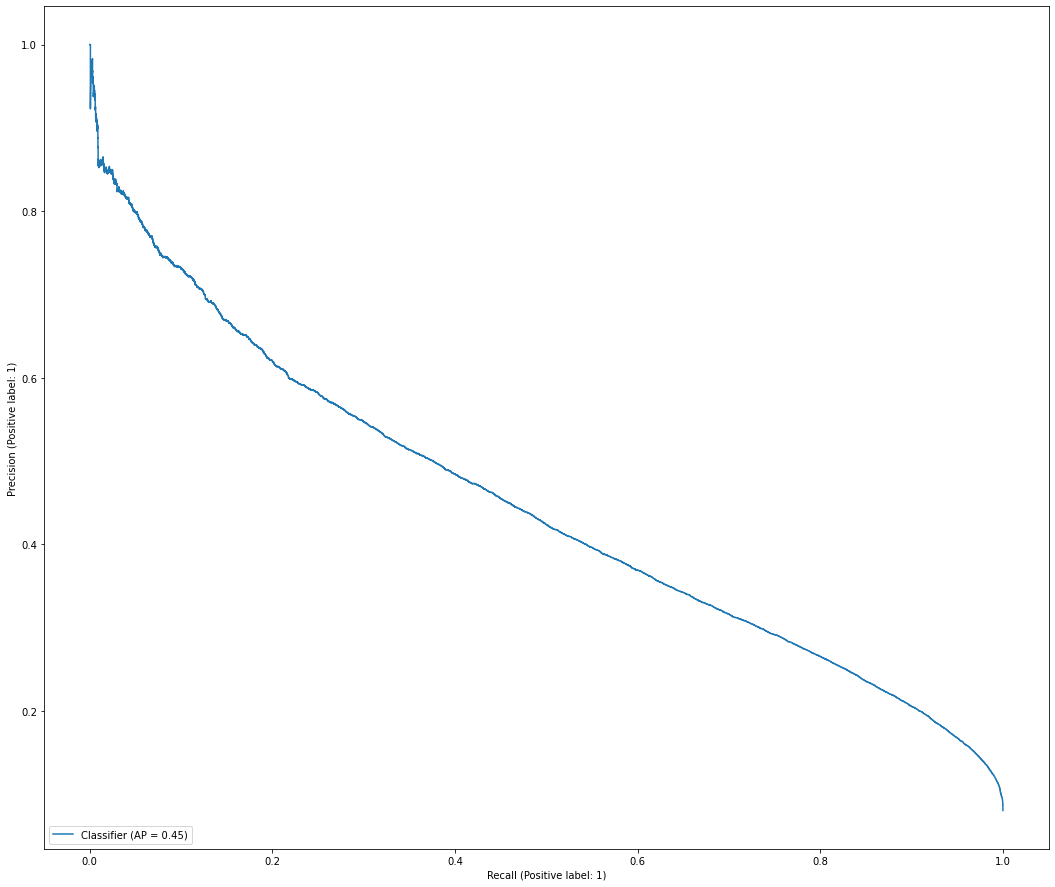

In [86]:
from sklearn.metrics import PrecisionRecallDisplay

plt.rcParams["figure.figsize"] = (18,15.5)

PrecisionRecallDisplay.from_predictions(y_train, y_train_prediction_proba_gbt)

plt.show()

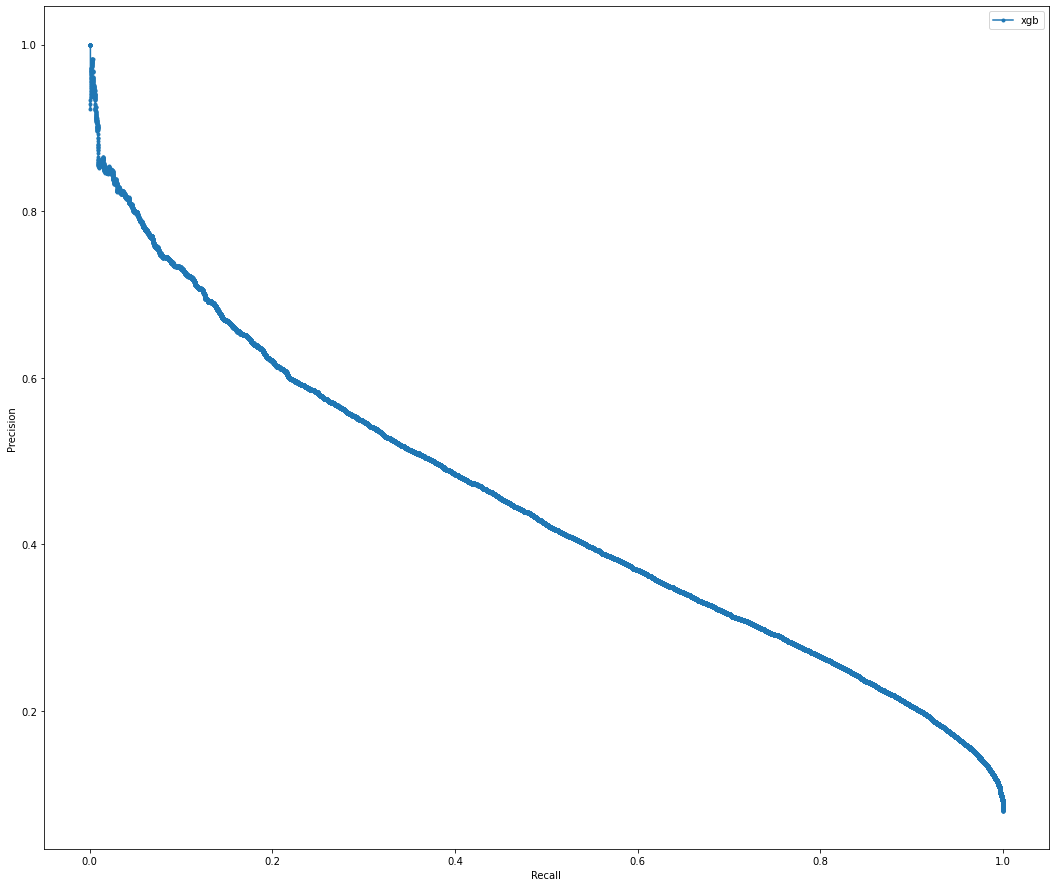

In [87]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_train, y_train_prediction_proba_gbt)

# plot the roc curve for the model
plt.plot(recall, precision, marker='.', label='xgb')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.547640, F2-Score=0.572


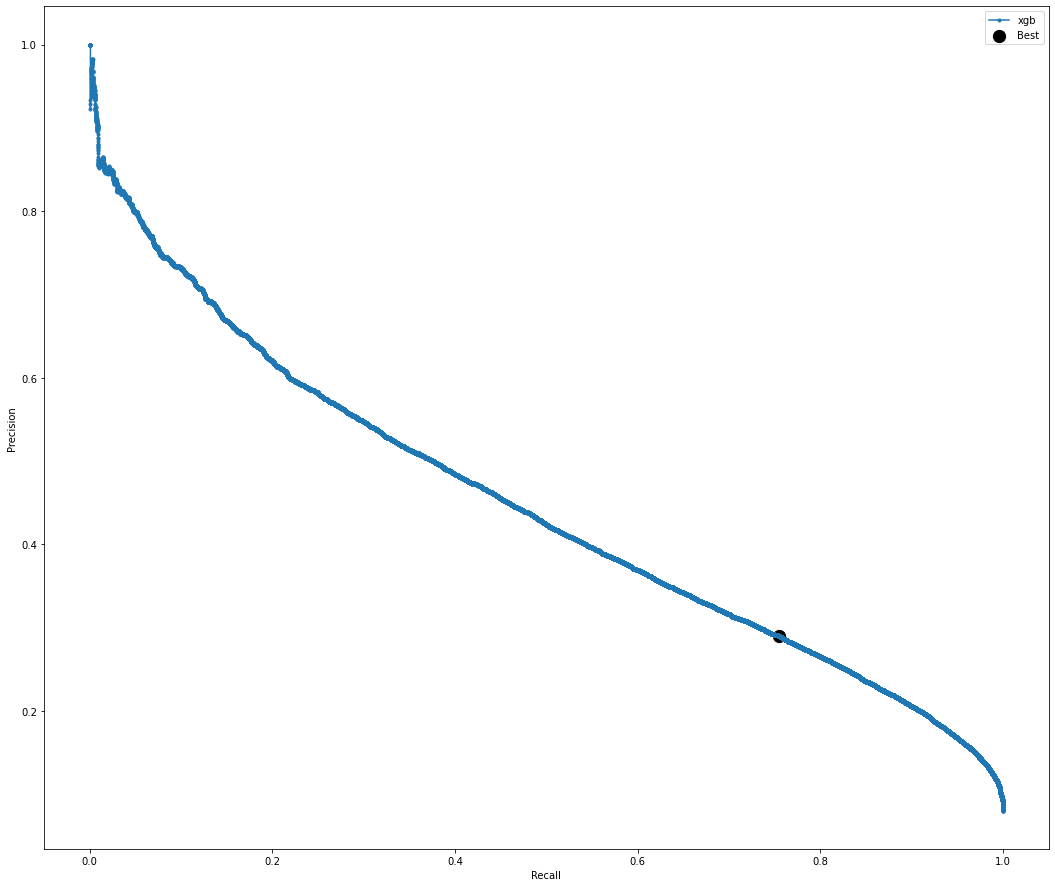

In [88]:
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_train, y_train_prediction_proba_gbt)

# convert to f2 score

f2 = (5 * precision * recall) / (4*precision + recall)

# locate the index of the largest f score
ix_f2 = argmax(f2)

print('Best Threshold=%f, F2-Score=%.3f' % (thresholds[ix_f2], f2[ix_f2]))

# plot the roc curve for the model
plt.plot(recall, precision, marker='.', label='xgb')
plt.scatter(recall[ix_f2], precision[ix_f2], marker='o', color='black', s = 150, label='Best')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# show the plot
plt.show()

In [89]:
print(fn, fp)

1799 12452


## 3.3 Comparaisons et Optimisation finale: 3 approches comparées<a class="anchor" id="e3"></a>

- Changement de seuil de prédiction pour modèle xgboost optimisé avec l'auc. le choix du seuil à lieu sur le set d'entrainement. les résultats pertinents (auc, f2_score, credit_score, recall, precision, specificité...) sont comparés sur les résultats obtenues par le nouveau seuil sur le set de validation.



- Optimisation sur quelques valeurs des hyperparamêtres autour des valeurs optimales trouvées avec l'auc, à partir d'une autre métrique + choix d'un seuil comme précédemment.
    - optimisation  sur la base du f2-score.
    - optimisation sur la base du score métier (crédit_score)

In [122]:
scoring = {
    'auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f2_score': make_scorer(fbeta_score, beta=2),
    'credit_score': make_scorer(credit_score, greater_is_better = False)
}

### Pour le "fine-tuning", on se concentre sur les hyperparams suivants: 
https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76


"(1) how many sub-trees to train; (2) the maximum tree depth (a regularization hyperparameter); (3) the learning rate; (4) the L1 (reg_alpha) and L2 (reg_ lambda) regularization rates that determine the extremity of weights on the leaves; (5) the complexity control (gamma=γ), a pseudo- regularization hyperparameter; and, (6) minimum child weight, another regularization hyperparameter."

## On ne conserve que les derniers fine-tuning réalisé dans cette étape (valeurs des hyperparamètres les plus ressérées testées) :

- pour ressérer les valeurs, on utilise l'auc. on cherche principalement à réduire le sur-apprentissage du modèle.

- puis sur le modèle optimal, on choisit un seuil basé sur le score métier (credit_score).

- pour finir on compare a deux dernières recherches d'hyperparamètres (sur des valeurs autour de l'optimum "auc") avec comme score le score métier et le f2_score directement. On change également les seuils pour la comparaison.



In [123]:
XGBClassifier().get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [124]:
## on opère une nouvelle cross-validation avec auc sur des valeurs proches des optima précédents. 
# RepeatedStratifiedKfold 3 fois.

df = pd.read_csv('selected_feature_dataset')


train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

X = train_df.drop(['TARGET', 'ID'], axis = 1)
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2)

In [125]:
#n_estimators = [192, 193, 194]

#learning_rate = [0.12, 0.13, 0.14]

#min_child_weight = [5, 6, 7]

#max_depth = [4, 5, 6]

#gamma = [0.16, 0.17, 0.18]

#reg_alpha = [45, 50, 55]

n_estimators = [180, 193, 200]

learning_rate = [0.1, 0.13, 0.2]

# Hyper-paramêtres pour réduire le sur-apprentissage du modèle. 

min_child_weight = [3, 6, 9]

max_depth = [3, 5, 8]

gamma = [0.1, 0.17, 0.22]

reg_alpha = [40, 50, 60]

param_grid = dict(gamma = gamma, learning_rate = learning_rate, max_depth = max_depth, min_child_weight = min_child_weight,
                  n_estimators = n_estimators, reg_alpha = reg_alpha )

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

model = XGBClassifier(scale_pos_weight = 11, tree_method = 'gpu_hist', verbosity = 2)

In [126]:
rand_search_xgb = RandomizedSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, refit = 'auc', cv=cv, verbose = 2)

In [127]:
rand_search_xgb_results = rand_search_xgb.fit(X_train, y_train, verbose = True)

Fitting 30 folds for each of 10 candidates, totalling 300 fits
[18:45:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [128]:
# summarize results
print("Best: %f using %s" % (rand_search_xgb_results.best_score_, rand_search_xgb_results.best_params_))

Best: 0.713319 using {'reg_alpha': 50, 'n_estimators': 180, 'min_child_weight': 9, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.17}


In [129]:
rand_search_xgb_results.cv_results_

{'mean_fit_time': array([14.43049478, 62.31798555, 24.75929656, 22.89874062, 13.08801976,
        14.04861655, 14.51802739, 69.20555978, 14.47550788, 67.8917412 ]),
 'std_fit_time': array([0.70976969, 1.07703719, 0.97506928, 0.51393836, 0.33595484,
        0.30975782, 0.40370459, 1.40280115, 0.68496751, 2.0474917 ]),
 'mean_score_time': array([0.1173862 , 0.18274453, 0.11958016, 0.10880911, 0.09434772,
        0.09654191, 0.09325064, 0.16565701, 0.09574414, 0.15322363]),
 'std_score_time': array([0.03905182, 0.05497722, 0.03862489, 0.02353548, 0.01363234,
        0.0141312 , 0.02315405, 0.02520867, 0.02151097, 0.02393399]),
 'param_reg_alpha': masked_array(data=[50, 40, 50, 60, 50, 50, 40, 40, 60, 40],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[200, 180, 200, 180, 180, 193, 200, 200, 200, 200],
              mask=[False, False

AUC training set : 0.8082031768640145
AUC validation set : 0.7865816700131958


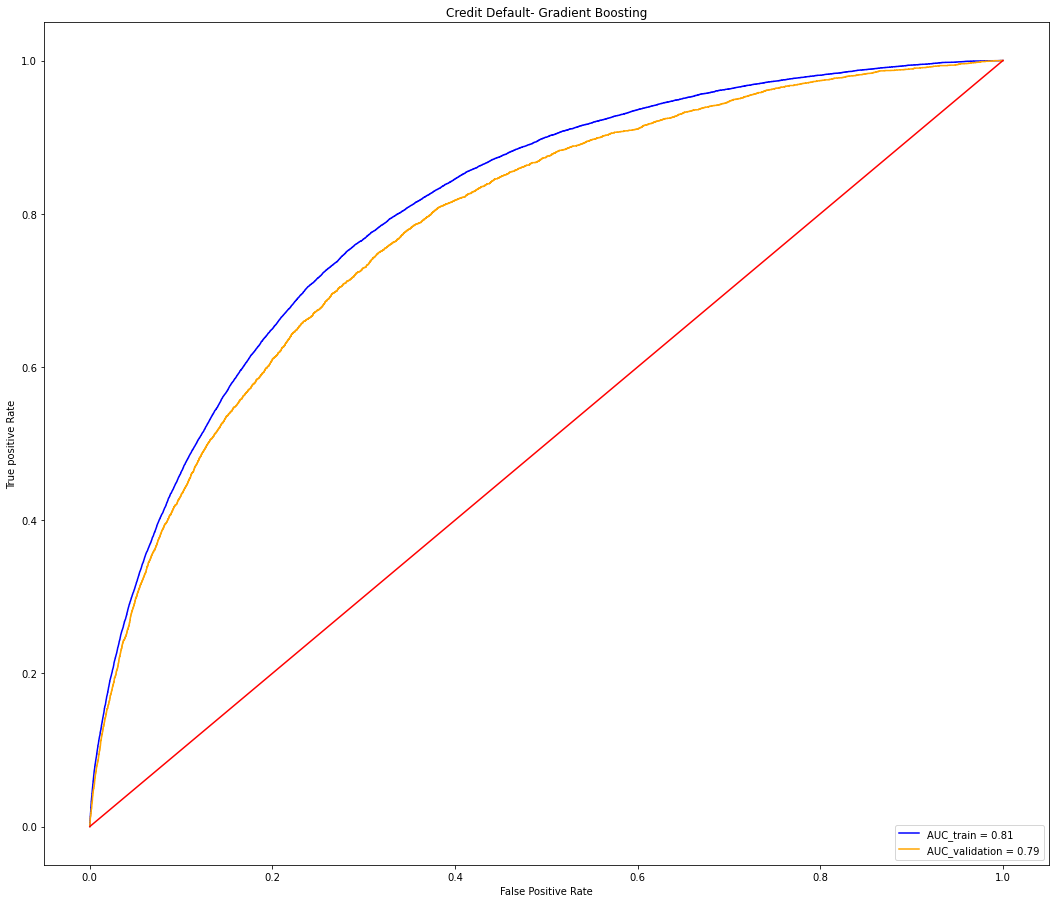

In [130]:
y_predict_train_xgb = rand_search_xgb_results.predict(X_train)

y_predict_test_xgb = rand_search_xgb_results.predict(X_test)

y_train_prediction_proba_xgb = rand_search_xgb_results.predict_proba(X_train)[:, 1]

y_test_prediction_proba_xgb = rand_search_xgb_results.predict_proba(X_test)[:, 1]


#graph roc curve

auc_train_xgb = roc_auc_score(y_train, y_train_prediction_proba_xgb)

auc_test_xgb = roc_auc_score(y_test, y_test_prediction_proba_xgb)

print('AUC training set : '+str(auc_train_xgb))

print('AUC validation set : '+str(auc_test_xgb))

fpr_train_xgb, tpr_train_xgb, _ = roc_curve(y_train, y_train_prediction_proba_xgb)

fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test, y_test_prediction_proba_xgb)

plt.plot(fpr_train_xgb, tpr_train_xgb, color='blue', label='AUC_train = %0.2f' % auc_train_xgb)
plt.plot(fpr_test_xgb, tpr_test_xgb, color='orange', label='AUC_validation = %0.2f' % auc_test_xgb)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), color='red')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.title('Credit Default- Gradient Boosting')
plt.savefig('roc_curve.png', dpi=300)
plt.show()

In [131]:
print('---------------------------------------------------')

print('matrice de confusion entrainement : ' )

tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train_xgb).ravel()
print("true neg : ", tn, "false pos : ", fp, " false neg : ", fn, " true pos : ", tp)
print("--------------------------------------------------")

print('classification report entrainement : ' )
print(classification_report(y_train, y_predict_train_xgb))


print('credit_score entrainement : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_train, y_predict_train_xgb, beta=2)

print('f2_score entrainement : ', fbs_gbt)

---------------------------------------------------
matrice de confusion entrainement : 
true neg :  167314 false pos :  58818  false neg :  5413  true pos :  14445
--------------------------------------------------
classification report entrainement : 
              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84    226132
         1.0       0.20      0.73      0.31     19858

    accuracy                           0.74    245990
   macro avg       0.58      0.73      0.57    245990
weighted avg       0.91      0.74      0.80    245990

credit_score entrainement :  112948
f2_score entrainement :  0.47300173548577235


In [132]:
print('AUC training set : '+str(auc_train_xgb))

print('AUC validation set : '+str(auc_test_xgb))


print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test_xgb).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, y_predict_test_xgb))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_test, y_predict_test_xgb, beta=2)

print('f2_score validation : ', fbs_gbt)

auc_gbt = roc_auc_score(y_test, y_predict_test_xgb)

print('auc_score validation : ', auc_gbt)

print('Precision :' , precision_score(y_test, y_predict_test_xgb))

print('recall :', recall_score(y_test, y_predict_test_xgb))

print('specificity : ', tn/(tn+fp))

AUC training set : 0.8082031768640145
AUC validation set : 0.7865816700131958
---------------------------------------------------
matrice de confusion validation : 
true neg :  41572 , false pos :  14961 , false neg :  1518 , true pos :  3447
--------------------------------------------------
classification report validation : 
              precision    recall  f1-score   support

         0.0       0.96      0.74      0.83     56533
         1.0       0.19      0.69      0.29      4965

    accuracy                           0.73     61498
   macro avg       0.58      0.71      0.56     61498
weighted avg       0.90      0.73      0.79     61498

credit_score validation :  30141
f2_score validation :  0.45037629350893693
auc_score validation :  0.7148089640769664
Precision : 0.1872555410691004
recall : 0.6942598187311179
specificity :  0.735358109422815


### Ayant significativement réduit l'overfitting du modèle on peut désormais travailler sur le seuil qui permet de prédire la classe sur de nouvelles données.

In [133]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# define thresholds
thresholds = np.arange(0, 1, 0.001)

#probs = y_test_prediction_proba_xgb
probs = y_train_prediction_proba_xgb

# evaluate each threshold
#scores = [credit_score(y_test, to_labels(probs, t)) for t in thresholds]
scores = [credit_score(y_train, to_labels(probs, t)) for t in thresholds]

# get best threshold
ix = np.argmin(scores)
print('Threshold=%.3f, credit-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.519, credit-Score=112645.00000


In [134]:
thresh = thresholds[ix]

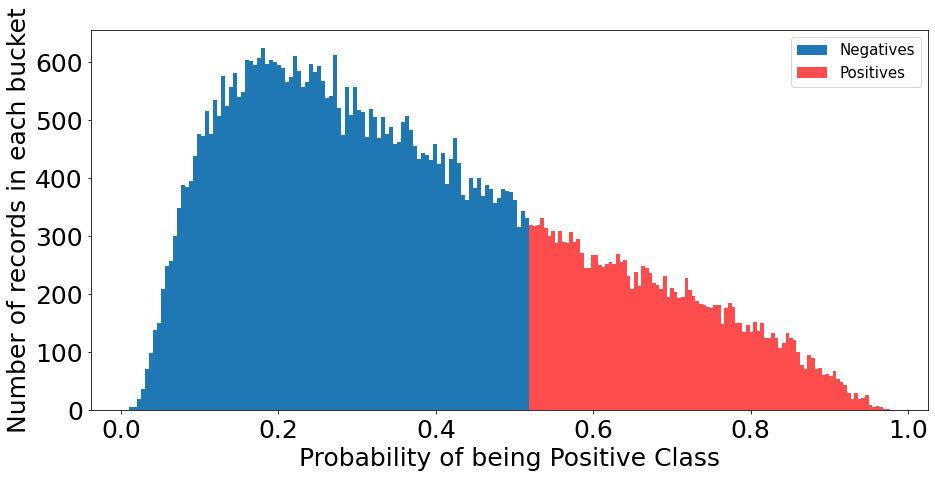

In [135]:
plt.figure(figsize=(15,7))
plt.hist(y_test_prediction_proba_xgb[y_test_prediction_proba_xgb<=thresh], bins=100, label='Negatives')
plt.hist(y_test_prediction_proba_xgb[y_test_prediction_proba_xgb>=thresh], bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

In [136]:
len(y_test)

61498

In [137]:
len(y_predict_test_xgb)

61498

In [138]:
roc_auc_score(y_test, y_predict_test_xgb)

0.7148089640769664

In [139]:
y_train_prediction_proba_xgb = rand_search_xgb_results.predict_proba(X_train)[:, 1]
y_test_prediction_proba_xgb = rand_search_xgb_results.predict_proba(X_test)[:, 1]

def assignation_nouv_seuil(proba, seuil):
    predict_prob_thresh = []
    for i in proba:
        if i >= seuil :
            predict_prob_thresh.append(1)
        else:
            predict_prob_thresh.append(0)
    return predict_prob_thresh

In [140]:
new_y_train_prob = assignation_nouv_seuil(y_train_prediction_proba_xgb, thresh)
new_y_test_prob = assignation_nouv_seuil(y_test_prediction_proba_xgb, thresh)

In [141]:
roc_auc_score(y_train, new_y_train_prob)

0.732950556017934

In [142]:
len(probs[probs>=thresh])

68032

In [143]:
len(y_test_prediction_proba_xgb[y_test_prediction_proba_xgb>=0.5])

18408

In [144]:
len(y_predict_test_xgb[y_predict_test_xgb>=0.5])

18408

In [145]:
len(y_test[y_test == 1])

4965

In [146]:
print('AUC training set : '+str(auc_train_xgb))

print('AUC validation set : '+str(auc_test_xgb))

print('---------------------------------------------------')

print('matrice de confusion entrainement : ' )

tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train_xgb).ravel()
print("true neg : ", tn, "false pos : ", fp, " false neg : ", fn, " true pos : ", tp)
print("--------------------------------------------------")

print('classification report entrainement : ' )
print(classification_report(y_train, y_predict_train_xgb))


print('credit_score entrainement : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_train, y_predict_train_xgb, beta=2)

print('f2_score entrainement : ', fbs_gbt)

auc_gbt = roc_auc_score(y_train, y_predict_train_xgb)

print('auc_score validation : ', auc_gbt)

print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test_xgb).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, y_predict_test_xgb))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_test, y_predict_test_xgb, beta=2)

print('f2_score validation : ', fbs_gbt)

auc_gbt = roc_auc_score(y_test, y_predict_test_xgb)

print('auc_score validation : ', auc_gbt)

print('Precision :' , precision_score(y_test, y_predict_test_xgb))

print('recall :', recall_score(y_test, y_predict_test_xgb))

print('specificity : ', tn/(tn+fp))

print('---------------------------------------------------')
print('#########################################################')
print('---------------------------------------------------')

#new_y_train_prob = assignation_nouv_seuil(y_train_prediction_proba_xgb, thresh)
#new_y_test_prob = assignation_nouv_seuil(y_test_prediction_proba_xgb, thresh)

print("résultats sur set d'entrainement basé sur le nouveau seuil:")
print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_train, new_y_train_prob).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_train, new_y_train_prob))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_train, new_y_train_prob, beta=2)

print('f2_score validation : ', fbs_gbt)

auc_gbt = roc_auc_score(y_train, new_y_train_prob)

print('auc_score validation : ', auc_gbt)

print('---------------------------------------------------')


print("résultats sur set de validation basé sur le nouveau seuil (déterminé sur le set d'entrainement):")
print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, new_y_test_prob).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, new_y_test_prob))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_test, new_y_test_prob, beta=2)

print('f2_score validation : ', fbs_gbt)

auc_gbt = roc_auc_score(y_test, new_y_test_prob)

print('auc_score validation : ', auc_gbt)

print('Precision :' , precision_score(y_test, new_y_test_prob))

print('recall :', recall_score(y_test, new_y_test_prob))

print('specificity : ', tn/(tn+fp))



AUC training set : 0.8082031768640145
AUC validation set : 0.7865816700131958
---------------------------------------------------
matrice de confusion entrainement : 
true neg :  167314 false pos :  58818  false neg :  5413  true pos :  14445
--------------------------------------------------
classification report entrainement : 
              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84    226132
         1.0       0.20      0.73      0.31     19858

    accuracy                           0.74    245990
   macro avg       0.58      0.73      0.57    245990
weighted avg       0.91      0.74      0.80    245990

credit_score entrainement :  112948
f2_score entrainement :  0.47300173548577235
auc_score validation :  0.733654963186816
---------------------------------------------------
matrice de confusion validation : 
true neg :  41572 , false pos :  14961 , false neg :  1518 , true pos :  3447
--------------------------------------------------
cl

# Que signifierait une nouvelle recherche d'hyperparamètres fondé sur autre chose que l'auc?

on chercherait à réduire artificiellement la capacité du modèle à reconnaitre le bon du mauvais pour assurer que le nouveau score soit meilleur.

cela semble une approche dangereuse. Il vaut probablement mieux laissé le modèle être le plus performant possible puis renégocier le seuil de prédiction pour réduire le risque métier.

Pour comparer cependant? on peut essayer quelques cross-validations supplémentaires fondé sur le f2_score ou notre credit_score. Si un modèle est significativement meilleur sans trop réduire l'auc-score alors il sera choisie.

In [147]:
n_estimators = [180, 193, 200]

learning_rate = [0.1, 0.13, 0.2]

# we have an overfitted model. try to reduce it with some additional tuning.

min_child_weight = [3, 6, 9]

max_depth = [3, 5, 8]

gamma = [0.1, 0.17, 0.22]

reg_alpha = [40, 50, 60]

param_grid = dict(gamma = gamma, learning_rate = learning_rate, max_depth = max_depth, min_child_weight = min_child_weight,
                  n_estimators = n_estimators, reg_alpha = reg_alpha )


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


model = XGBClassifier(scale_pos_weight = 11, tree_method = 'gpu_hist', verbosity = 2)

rand_search_xgb = RandomizedSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, refit = 'f2_score', cv=cv, verbose = 2)

rand_search_xgb_results = rand_search_xgb.fit(X_train, y_train, verbose = True)


Fitting 30 folds for each of 10 candidates, totalling 300 fits
[19:10:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Best: 0.449518 using {'reg_alpha': 60, 'n_estimators': 200, 'min_child_weight': 6, 'max_depth': 5, 'learning_rate': 0.13, 'gamma': 0.1}


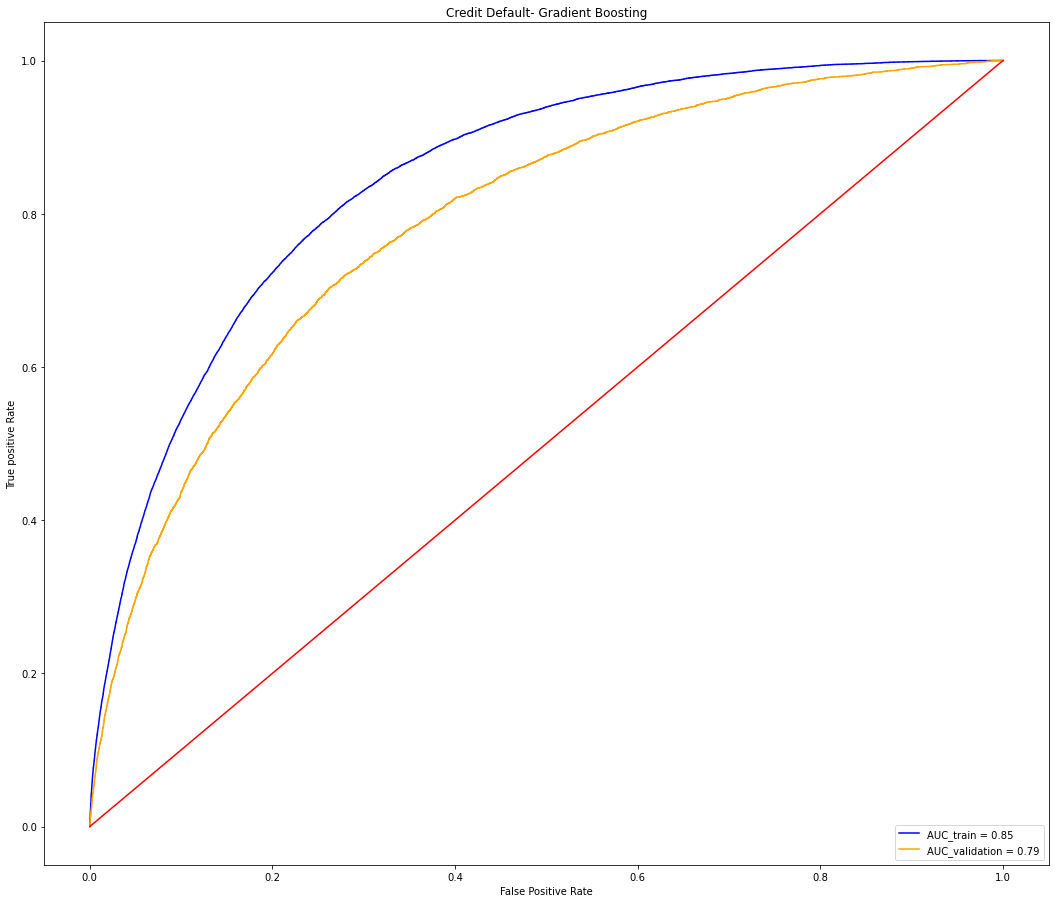

AUC training set : 0.8462223184322128
AUC validation set : 0.7899717031122406


In [148]:

# summarize results
print("Best: %f using %s" % (rand_search_xgb_results.best_score_, rand_search_xgb_results.best_params_))

rand_search_xgb_results.cv_results_

y_predict_train_xgb = rand_search_xgb_results.predict(X_train)

y_predict_test_xgb = rand_search_xgb_results.predict(X_test)

y_train_prediction_proba_xgb = rand_search_xgb_results.predict_proba(X_train)[:, 1]

y_test_prediction_proba_xgb = rand_search_xgb_results.predict_proba(X_test)[:, 1]


#graph roc curve

auc_train_xgb = roc_auc_score(y_train, y_train_prediction_proba_xgb)

auc_test_xgb = roc_auc_score(y_test, y_test_prediction_proba_xgb)

fpr_train_xgb, tpr_train_xgb, _ = roc_curve(y_train, y_train_prediction_proba_xgb)

fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test, y_test_prediction_proba_xgb)

plt.plot(fpr_train_xgb, tpr_train_xgb, color='blue', label='AUC_train = %0.2f' % auc_train_xgb)
plt.plot(fpr_test_xgb, tpr_test_xgb, color='orange', label='AUC_validation = %0.2f' % auc_test_xgb)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), color='red')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.title('Credit Default- Gradient Boosting')
plt.savefig('roc_curve.png', dpi=300)
plt.show()

print('AUC training set : '+str(auc_train_xgb))

print('AUC validation set : '+str(auc_test_xgb))


In [149]:
print('AUC training set : '+str(auc_train_xgb))

print('AUC validation set : '+str(auc_test_xgb))

print('---------------------------------------------------')

print('matrice de confusion entrainement : ' )

tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train_xgb).ravel()
print("true neg : ", tn, "false pos : ", fp, " false neg : ", fn, " true pos : ", tp)
print("--------------------------------------------------")

print('classification report entrainement : ' )
print(classification_report(y_train, y_predict_train_xgb))


print('credit_score entrainement : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_train, y_predict_train_xgb, beta=2)

print('f2_score entrainement : ', fbs_gbt)

auc_gbt = roc_auc_score(y_train, y_predict_train_xgb)

print('auc_score validation : ', auc_gbt)

print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test_xgb).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, y_predict_test_xgb))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_test, y_predict_test_xgb, beta=2)

print('f2_score validation : ', fbs_gbt)

auc_gbt = roc_auc_score(y_test, y_predict_test_xgb)

print('auc_score validation : ', auc_gbt)

print('Precision :' , precision_score(y_test, y_predict_test_xgb))

print('recall :', recall_score(y_test, y_predict_test_xgb))

print('specificity : ', tn/(tn+fp))

AUC training set : 0.8462223184322128
AUC validation set : 0.7899717031122406
---------------------------------------------------
matrice de confusion entrainement : 
true neg :  173431 false pos :  52701  false neg :  4664  true pos :  15194
--------------------------------------------------
classification report entrainement : 
              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86    226132
         1.0       0.22      0.77      0.35     19858

    accuracy                           0.77    245990
   macro avg       0.60      0.77      0.60    245990
weighted avg       0.91      0.77      0.82    245990

credit_score entrainement :  99341
f2_score entrainement :  0.5156556503560108
auc_score validation :  0.7660391474799467
---------------------------------------------------
matrice de confusion validation : 
true neg :  42971 , false pos :  13562 , false neg :  1620 , true pos :  3345
--------------------------------------------------
cla

Threshold=0.499, credit-Score=99293.00000


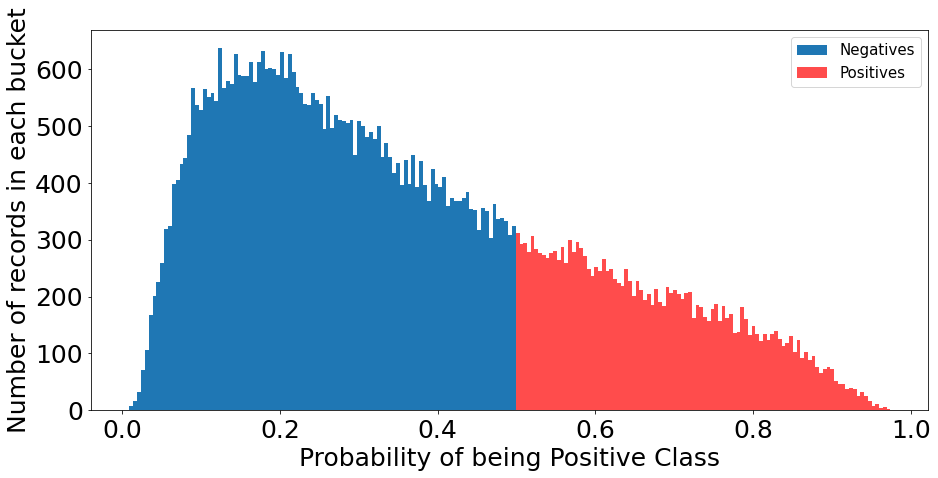

AUC training set : 0.8462223184322128
AUC validation set : 0.7899717031122406
---------------------------------------------------
matrice de confusion entrainement : 
true neg :  173431 false pos :  52701  false neg :  4664  true pos :  15194
--------------------------------------------------
classification report entrainement : 
              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86    226132
         1.0       0.22      0.77      0.35     19858

    accuracy                           0.77    245990
   macro avg       0.60      0.77      0.60    245990
weighted avg       0.91      0.77      0.82    245990

credit_score entrainement :  99341
f2_score entrainement :  0.5156556503560108
auc_score validation :  0.7660391474799467
---------------------------------------------------
matrice de confusion validation : 
true neg :  42971 , false pos :  13562 , false neg :  1620 , true pos :  3345
--------------------------------------------------
cla

In [150]:
# define thresholds
thresholds = np.arange(0, 1, 0.001)

#probs = y_test_prediction_proba_xgb
probs = y_train_prediction_proba_xgb

# evaluate each threshold
#scores = [credit_score(y_test, to_labels(probs, t)) for t in thresholds]
scores = [credit_score(y_train, to_labels(probs, t)) for t in thresholds]

# get best threshold
ix = np.argmin(scores)
print('Threshold=%.3f, credit-Score=%.5f' % (thresholds[ix], scores[ix]))

thresh = thresholds[ix]

plt.figure(figsize=(15,7))
plt.hist(y_test_prediction_proba_xgb[y_test_prediction_proba_xgb<=thresh], bins=100, label='Negatives')
plt.hist(y_test_prediction_proba_xgb[y_test_prediction_proba_xgb>=thresh], bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 


new_y_train_prob = assignation_nouv_seuil(y_train_prediction_proba_xgb, thresh)
new_y_test_prob = assignation_nouv_seuil(y_test_prediction_proba_xgb, thresh)

roc_auc_score(y_train, new_y_train_prob)


print('AUC training set : '+str(auc_train_xgb))

print('AUC validation set : '+str(auc_test_xgb))

print('---------------------------------------------------')

print('matrice de confusion entrainement : ' )

tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train_xgb).ravel()
print("true neg : ", tn, "false pos : ", fp, " false neg : ", fn, " true pos : ", tp)
print("--------------------------------------------------")

print('classification report entrainement : ' )
print(classification_report(y_train, y_predict_train_xgb))


print('credit_score entrainement : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_train, y_predict_train_xgb, beta=2)

print('f2_score entrainement : ', fbs_gbt)

auc_gbt = roc_auc_score(y_train, y_predict_train_xgb)

print('auc_score validation : ', auc_gbt)

print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test_xgb).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, y_predict_test_xgb))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_test, y_predict_test_xgb, beta=2)

print('f2_score validation : ', fbs_gbt)

auc_gbt = roc_auc_score(y_test, y_predict_test_xgb)

print('auc_score validation : ', auc_gbt)

print('Precision :' , precision_score(y_test, y_predict_test_xgb))

print('recall :', recall_score(y_test, y_predict_test_xgb))

print('specificity : ', tn/(tn+fp))

print('---------------------------------------------------')
print('#########################################################')
print('---------------------------------------------------')

#new_y_train_prob = assignation_nouv_seuil(y_train_prediction_proba_xgb, thresh)
#new_y_test_prob = assignation_nouv_seuil(y_test_prediction_proba_xgb, thresh)

print("résultats sur set d'entrainement basé sur le nouveau seuil:")
print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_train, new_y_train_prob).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_train, new_y_train_prob))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_train, new_y_train_prob, beta=2)

print('f2_score validation : ', fbs_gbt)

auc_gbt = roc_auc_score(y_train, new_y_train_prob)

print('auc_score validation : ', auc_gbt)

print('---------------------------------------------------')


print("résultats sur set de validation basé sur le nouveau seuil (déterminé sur le set d'entrainement):")
print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, new_y_test_prob).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, new_y_test_prob))

print('credit_score validation : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_test, new_y_test_prob, beta=2)

print('f2_score validation : ', fbs_gbt)

auc_gbt = roc_auc_score(y_test, new_y_test_prob)

print('auc_score validation : ', auc_gbt)

print('Precision :' , precision_score(y_test, new_y_test_prob))

print('recall :', recall_score(y_test, new_y_test_prob))

print('specificity : ', tn/(tn+fp))



### Enfin, la même chose avec le score credit.

In [151]:
n_estimators = [180, 193, 200]

learning_rate = [0.1, 0.13, 0.2]

# we have an overfitted model. try to reduce it with some additional tuning.

min_child_weight = [3, 6, 9]

max_depth = [3, 5, 8]

gamma = [0.1, 0.17, 0.22]

reg_alpha = [40, 50, 60]

param_grid = dict(gamma = gamma, learning_rate = learning_rate, max_depth = max_depth, min_child_weight = min_child_weight,
                  n_estimators = n_estimators, reg_alpha = reg_alpha )

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


model = XGBClassifier(scale_pos_weight = 11, tree_method = 'gpu_hist', verbosity = 2)

rand_search_xgb = RandomizedSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, refit = 'credit_score', cv=cv, verbose = 2)

rand_search_xgb_results = rand_search_xgb.fit(X_train, y_train, verbose = True)



Fitting 30 folds for each of 10 candidates, totalling 300 fits
[19:41:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Best: -12076.566667 using {'reg_alpha': 60, 'n_estimators': 200, 'min_child_weight': 9, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.22}


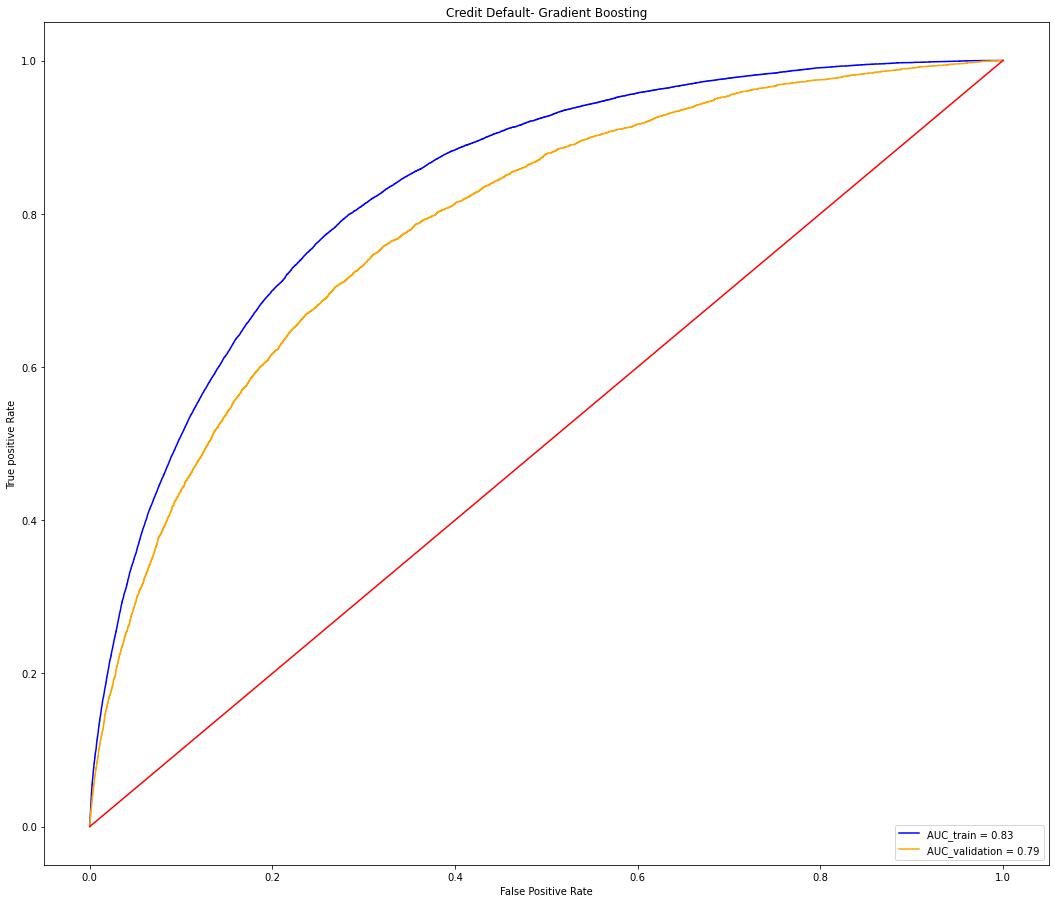

AUC training set : 0.834975763378035
AUC validation set : 0.7890913752858195
---------------------------------------------------
matrice de confusion entrainement : 
true neg :  171431 false pos :  54701  false neg :  4896  true pos :  14962
--------------------------------------------------
classification report entrainement : 
              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85    226132
         1.0       0.21      0.75      0.33     19858

    accuracy                           0.76    245990
   macro avg       0.59      0.76      0.59    245990
weighted avg       0.91      0.76      0.81    245990

credit_score entrainement :  103661
f2_score entrainement :  0.5017606224219456
auc_score validation :  0.75577547712563
---------------------------------------------------
matrice de confusion validation : 
true neg :  42470 , false pos :  14063 , false neg :  1590 , true pos :  3375
--------------------------------------------------
class

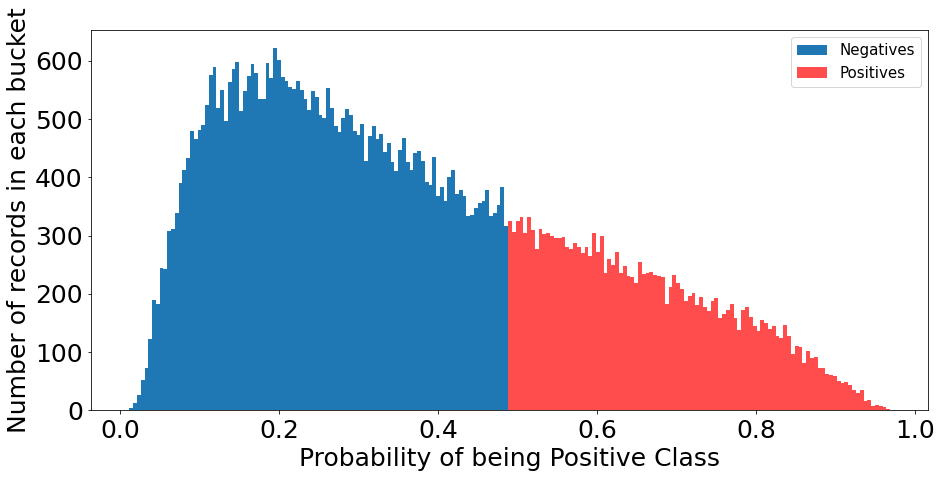

AUC training set : 0.834975763378035
AUC validation set : 0.7890913752858195
---------------------------------------------------
matrice de confusion entrainement : 
true neg :  171431 false pos :  54701  false neg :  4896  true pos :  14962
--------------------------------------------------
classification report entrainement : 
              precision    recall  f1-score   support

         0.0       0.97      0.76      0.85    226132
         1.0       0.21      0.75      0.33     19858

    accuracy                           0.76    245990
   macro avg       0.59      0.76      0.59    245990
weighted avg       0.91      0.76      0.81    245990

credit_score entrainement :  103661
f2_score entrainement :  0.5017606224219456
auc_score validation :  0.75577547712563
---------------------------------------------------
matrice de confusion validation : 
true neg :  42470 , false pos :  14063 , false neg :  1590 , true pos :  3375
--------------------------------------------------
class

In [152]:


# summarize results
print("Best: %f using %s" % (rand_search_xgb_results.best_score_, rand_search_xgb_results.best_params_))


y_predict_train_xgb = rand_search_xgb_results.predict(X_train)

y_predict_test_xgb = rand_search_xgb_results.predict(X_test)

y_train_prediction_proba_xgb = rand_search_xgb_results.predict_proba(X_train)[:, 1]

y_test_prediction_proba_xgb = rand_search_xgb_results.predict_proba(X_test)[:, 1]


#graph roc curve

auc_train_xgb = roc_auc_score(y_train, y_train_prediction_proba_xgb)

auc_test_xgb = roc_auc_score(y_test, y_test_prediction_proba_xgb)

fpr_train_xgb, tpr_train_xgb, _ = roc_curve(y_train, y_train_prediction_proba_xgb)

fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test, y_test_prediction_proba_xgb)

plt.plot(fpr_train_xgb, tpr_train_xgb, color='blue', label='AUC_train = %0.2f' % auc_train_xgb)
plt.plot(fpr_test_xgb, tpr_test_xgb, color='orange', label='AUC_validation = %0.2f' % auc_test_xgb)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), color='red')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.title('Credit Default- Gradient Boosting')
plt.savefig('roc_curve.png', dpi=300)
plt.show()

print('AUC training set : '+str(auc_train_xgb))

print('AUC validation set : '+str(auc_test_xgb))


print('---------------------------------------------------')

print('matrice de confusion entrainement : ' )

tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train_xgb).ravel()
print("true neg : ", tn, "false pos : ", fp, " false neg : ", fn, " true pos : ", tp)
print("--------------------------------------------------")

print('classification report entrainement : ' )
print(classification_report(y_train, y_predict_train_xgb))


print('credit_score entrainement : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_train, y_predict_train_xgb, beta=2)

print('f2_score entrainement : ', fbs_gbt)

auc_gbt = roc_auc_score(y_train, y_predict_train_xgb)

print('auc_score validation : ', auc_gbt)

print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test_xgb).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, y_predict_test_xgb))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_test, y_predict_test_xgb, beta=2)

print('f2_score validation : ', fbs_gbt)

auc_gbt = roc_auc_score(y_test, y_predict_test_xgb)

print('auc_score validation : ', auc_gbt)

print('Precision :' , precision_score(y_test, y_predict_test_xgb))

print('recall :', recall_score(y_test, y_predict_test_xgb))

print('specificity : ', tn/(tn+fp))

# define thresholds
thresholds = np.arange(0, 1, 0.001)

#probs = y_test_prediction_proba_xgb
probs = y_train_prediction_proba_xgb

# evaluate each threshold
#scores = [credit_score(y_test, to_labels(probs, t)) for t in thresholds]
scores = [credit_score(y_train, to_labels(probs, t)) for t in thresholds]

# get best threshold
ix = np.argmin(scores)
print('Threshold=%.3f, credit-Score=%.5f' % (thresholds[ix], scores[ix]))

thresh = thresholds[ix]

plt.figure(figsize=(15,7))
plt.hist(y_test_prediction_proba_xgb[y_test_prediction_proba_xgb<=thresh], bins=100, label='Negatives')
plt.hist(y_test_prediction_proba_xgb[y_test_prediction_proba_xgb>=thresh], bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 


new_y_train_prob = assignation_nouv_seuil(y_train_prediction_proba_xgb, thresh)
new_y_test_prob = assignation_nouv_seuil(y_test_prediction_proba_xgb, thresh)

roc_auc_score(y_train, new_y_train_prob)


print('AUC training set : '+str(auc_train_xgb))

print('AUC validation set : '+str(auc_test_xgb))

print('---------------------------------------------------')

print('matrice de confusion entrainement : ' )

tn, fp, fn, tp = confusion_matrix(y_train, y_predict_train_xgb).ravel()
print("true neg : ", tn, "false pos : ", fp, " false neg : ", fn, " true pos : ", tp)
print("--------------------------------------------------")

print('classification report entrainement : ' )
print(classification_report(y_train, y_predict_train_xgb))


print('credit_score entrainement : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_train, y_predict_train_xgb, beta=2)

print('f2_score entrainement : ', fbs_gbt)

auc_gbt = roc_auc_score(y_train, y_predict_train_xgb)

print('auc_score validation : ', auc_gbt)

print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test_xgb).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, y_predict_test_xgb))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_test, y_predict_test_xgb, beta=2)

print('f2_score validation : ', fbs_gbt)

auc_gbt = roc_auc_score(y_test, y_predict_test_xgb)

print('auc_score validation : ', auc_gbt)

print('Precision :' , precision_score(y_test, y_predict_test_xgb))

print('recall :', recall_score(y_test, y_predict_test_xgb))

print('specificity : ', tn/(tn+fp))

print('---------------------------------------------------')
print('#########################################################')
print('---------------------------------------------------')

#new_y_train_prob = assignation_nouv_seuil(y_train_prediction_proba_xgb, thresh)
#new_y_test_prob = assignation_nouv_seuil(y_test_prediction_proba_xgb, thresh)

print("résultats sur set d'entrainement basé sur le nouveau seuil:")
print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_train, new_y_train_prob).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_train, new_y_train_prob))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_train, new_y_train_prob, beta=2)

print('f2_score validation : ', fbs_gbt)

auc_gbt = roc_auc_score(y_train, new_y_train_prob)

print('auc_score validation : ', auc_gbt)

print('---------------------------------------------------')


print("résultats sur set de validation basé sur le nouveau seuil (déterminé sur le set d'entrainement):")
print('---------------------------------------------------')

print('matrice de confusion validation : ' )

tn, fp, fn, tp = confusion_matrix(y_test, new_y_test_prob).ravel()
print("true neg : ", tn, ", false pos : ", fp, ", false neg : ", fn, ", true pos : ", tp)
print("--------------------------------------------------")

print('classification report validation : ' )
print(classification_report(y_test, new_y_test_prob))


print('credit_score validation : ',credit_metric(fn,fp))

fbs_gbt = fbeta_score(y_test, new_y_test_prob, beta=2)

print('f2_score validation : ', fbs_gbt)

auc_gbt = roc_auc_score(y_test, new_y_test_prob)

print('auc_score validation : ', auc_gbt)

print('Precision :' , precision_score(y_test, new_y_test_prob))

print('recall :', recall_score(y_test, new_y_test_prob))

print('specificity : ', tn/(tn+fp))



In [153]:
thresholds[ix]

0.488

# 4. Conclusion: récap' des résultats et export du modèle final<a class="anchor" id="ccl"></a>

### résultats XGboost optimisée auc + résultats nouveau seuil sur base de credit_score:

### résultats XGboost optimisée f2_score + résultats nouveau seuil sur base de credit_score:

### résultats XGboost optimisée credit_score + résultats (vérification) nouveau seuil sur base de credit_score:

# Quelques conclusions:

### L'optimisation sur la base du f2_score et du credit_score n'ont pas améliorer significativement la prédiction. 

### Après de nombreuses tentatives et modulation des plages d'hyperparamêtres, aucun des modèles ne semble être significativement meilleur dans sa prédiction sur le set de validation. Du point de vue du sur-apprentissage par contre, il est pratiquemment éliminé dans le cas de la cross-validation avec AUC.

- On note que le modèle lgbm largement utilisé sur kaggle pour ce problème a également un surapprentissage trés fort. cela s'explique par la nature des compétitions kaggle dans lesquels toute amélioration de la prédiction est bonne à prendre.

- Dans notre perspective métier par contre, le sur-apprentissage pour un produit destiné à une "start-up" signifie que les évolutions des clients potentiels à l'avenir pourront réduire significativement l'efficacité prédictive du modèle. si les données disponibles correspondent à une niche de premiers utilisateurs, ils ne correspondront certainement pas aux données futures lorsque l'entreprise change d'échelle.

- Il vaut donc mieux choisir le modèle xgboost hyper-paramétré avec l'auc. il minimise d'ailleurs mieux les faux négatifs avec un seuil approprié.

## Enfin, à propos du changement de seuil pour le XGBoost - auc.

- On constate que le seuil déterminé sur le set d'entrainement ne permet pas d'améliorer la métrique métier sur le set de validation. le nouveau seuil est trop proche de 0.5 pour un gain significatif lors de la prédiction sur de nouvelles données.

- en changeant le seuil, le nombre de faux négatifs (client à qui l'on donne le prêt alors qu'il ne peut pas remboursé) à augmenter. Si l'on considère le score métier (ou un faux négatif est 10 fois plus coûteux qu'un faux positifs), un changement de seuil sur la base du set d'entraînement, après avoir régler le problème de déséquilibre entre classe majoritaire et minoritaire, peut donner de très mauvais résultats sur de nouvelles données.

- Les poids visant à rééquilibré classe majoritaire et minoritaire, hyperparamétré avec l'auc, ont donc déja relativement bien jouer leur rôle de sorte que le modèle fait la partition entre "bons" et "mauvais" clients de manière optimale et sans être trop dépendant de la structure des données des clients d'entrainement (overfitting réduit). 

### Conclusion, on conserve le modèle sans changement de seuil et sans hyper-paramétrage sur la base du f2_score et du credit_score. C'est un choix qui doit en fait être laissé au client selon les marges bénéficiaires qu'il dégage et les pertes financières qu'il est prêt à accepter pour un modèle plus robuste qui servira plus longtemps avant de devoir être ré-entrainé.

In [154]:
XGBClassifier().get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [155]:
df = pd.read_csv('selected_feature_dataset')


train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]

X = train_df.drop(['TARGET', 'ID'], axis = 1)
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2)

In [156]:
model = XGBClassifier(gamma = 0.17, learning_rate = 0.2, max_depth = 3, min_child_weight = 9, n_estimators = 180,
                      reg_alpha = 50, scale_pos_weight = 11, tree_method = 'gpu_hist').fit(X_train, y_train)

[13:41:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


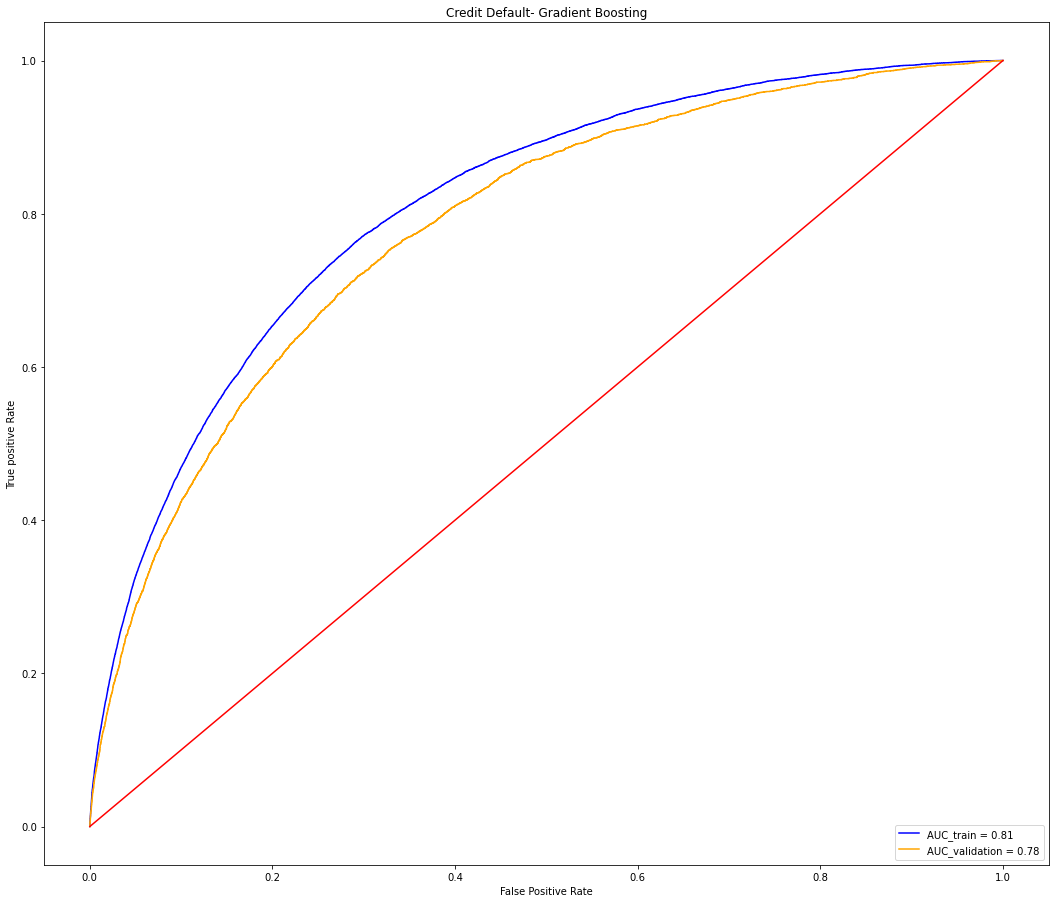

AUC training set : 0.8095939933232671
AUC validation set : 0.7828195881776864


In [157]:
y_predict_train_xgb = model.predict(X_train)

y_predict_test_xgb = model.predict(X_test)

y_train_prediction_proba_xgb = model.predict_proba(X_train)[:, 1]

y_test_prediction_proba_xgb = model.predict_proba(X_test)[:, 1]


#graph roc curve

auc_train_xgb = roc_auc_score(y_train, y_train_prediction_proba_xgb)

auc_test_xgb = roc_auc_score(y_test, y_test_prediction_proba_xgb)

fpr_train_xgb, tpr_train_xgb, _ = roc_curve(y_train, y_train_prediction_proba_xgb)

fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test, y_test_prediction_proba_xgb)

plt.plot(fpr_train_xgb, tpr_train_xgb, color='blue', label='AUC_train = %0.2f' % auc_train_xgb)
plt.plot(fpr_test_xgb, tpr_test_xgb, color='orange', label='AUC_validation = %0.2f' % auc_test_xgb)
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), color='red')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True positive Rate')
plt.title('Credit Default- Gradient Boosting')
plt.savefig('roc_curve.png', dpi=300)
plt.show()

print('AUC training set : '+str(auc_train_xgb))

print('AUC validation set : '+str(auc_test_xgb))


In [158]:
import pickle
# save model:
pickle.dump(model, open("model_final.pickle.dat", "wb"))